In [1]:
import os
import gc
from glob import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import libtiff

warnings.filterwarnings(action='ignore')
libtiff.libtiff_ctypes.suppress_warnings()

In [2]:
SLIDE_PATH = '/workspace/data3/A100_data/stm/20210914_stomach_carcicoma/A100_00220_02_stm_c1.svs'

In [3]:
import openslide

In [4]:
wsi_slide = openslide.OpenSlide(SLIDE_PATH)

In [5]:
wsi_slide

OpenSlide('/workspace/data3/A100_data/stm/20210914_stomach_carcicoma/A100_00220_02_stm_c1.svs')

In [6]:
# wsi_slide.level_downsamples
# wsi_slide.level_dimensions

In [7]:
wsi_slide.level_dimensions

((57768, 48464), (14442, 12116), (3610, 3029))

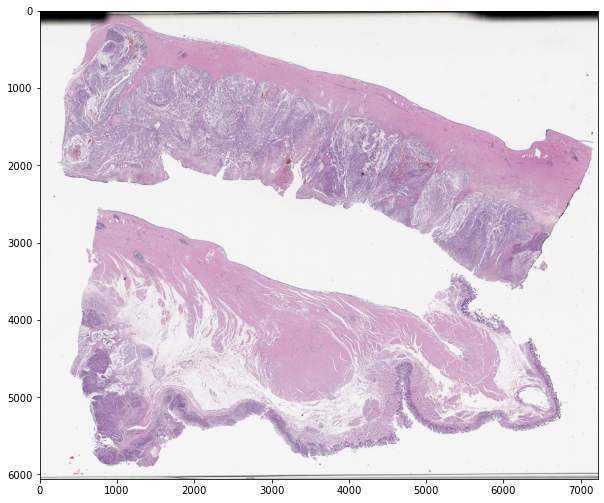

In [15]:
# level3의 전체 영상을 불러오는 경우
# level_dimensions에 없는 level의 영상을 사용하고자 하는 경우는 상위 level의 이미지를 불러와 resize
LEVEL = 3
w_, h_ = wsi_slide.level_dimensions[LEVEL//2]
wsi_array_lv2 = np.array(wsi_slide.read_region([0, 0], LEVEL//2, [w_, h_]))
wsi_array_lv3 = cv2.resize(wsi_array_lv2, (w_//2, h_//2), interpolation=cv2.INTER_AREA)

plt.figure(figsize=(10, 10))
plt.imshow(wsi_array_lv3)
plt.show()

### MPP (micrometer per pixel)

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRrLUAkJzvhB6xMMJy01xUcc1fSWZUFoelPnQ&usqp=CAU">

1 pixel 당 몇 μm인지? mpp가 작을수록 고배율 스캐너로 스캔된 것

- mpp == 0.25 → 원본 400 배율 (40X)
- mpp == 0.50 → 원본 200 배율 (20X)

##### ex) mpp가 0.25, 0.5인 두 slides가 있을 때, 동일한 100 배율(10X)로 맞추기 위해서는
- 0.25: level2 (10X) read_region
- 0.50: level0 (20X) read_region → resize (10X)



OpenSlide 인스턴스의 `properties`를 통해 WSI의 meta data 확인이 가능한데, 그 중 mpp를 확인

In [9]:
for k, v in wsi_slide.properties.items():
    print(k, v)
# mpp == 0.25 (40X) -> level2 (10X)
# mpp == 0.50 (20X) -> level0 (20X) -> resize (10X)

aperio.AppMag 20
aperio.Date 09/01/20
aperio.DisplayColor 0
aperio.Exposure Scale 0.000001
aperio.Exposure Time 32
aperio.Filename anonymized
aperio.Focus Offset 0.000000
aperio.ICC Profile AT2
aperio.ImageID 1210147
aperio.Left 18.877777
aperio.LineAreaXOffset 0.021802
aperio.LineAreaYOffset -0.000598
aperio.LineCameraSkew -0.000778
aperio.MPP 0.5029
aperio.OriginalHeight 48564
aperio.OriginalWidth 58928
aperio.Parmset anonymized
aperio.ScanScope ID anonymized
aperio.SessonMode NR
aperio.StripeWidth 2032
aperio.Time 03:55:06
aperio.Time Zone GMT+09:00
aperio.Top 24.549700
aperio.User anonymized
openslide.comment Aperio Image Library v12.0.16 
58928x48564 [0,100 57768x48464] (240x240) JPEG/RGB Q=30|AppMag = 20|StripeWidth = 2032|ScanScope ID = anonymized|Filename = anonymized|Date = 09/01/20|Time = 03:55:06|Time Zone = GMT+09:00|User = anonymized|Parmset = anonymized|MPP = 0.5029|Left = 18.877777|Top = 24.549700|LineCameraSkew = -0.000778|LineAreaXOffset = 0.021802|LineAreaYOffset = -0

In [13]:
# patching : sliding window 방식으로 50배율 (level4)의 (512, 512) 크기의 patch 추출
LEVEL = 4
PATCH_SIZE = (512, 512) # (width, height)

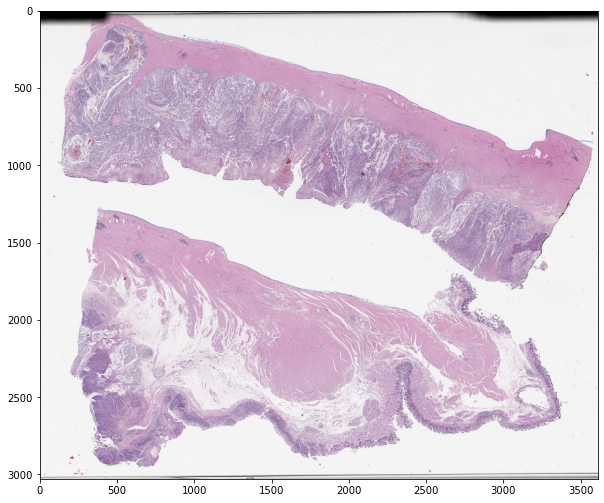

In [14]:
wsi_slide = openslide.OpenSlide(SLIDE_PATH)
w_, h_ = wsi_slide.level_dimensions[LEVEL//2]
wsi_array = np.array(wsi_slide.read_region([0, 0], LEVEL//2, [w_, h_]))[...,:3]

plt.figure(figsize=(10, 10))
plt.imshow(wsi_array)
plt.show()

In [15]:
wsi_array.shape # h, w, c

(3029, 3610, 3)

In [ ]:
for i in range(0, h_, PATCH_SIZE[1]):
    if i+PATCH_SIZE[1] > h_:
        continue
    for j in range(0, w_, PATCH_SIZE[0]):
        if j+PATCH_SIZE[0] > w_:
            continue
        
        patch = wsi_array[i:i+PATCH_SIZE[1], j:j+PATCH_SIZE[0], :]
        plt.imshow(patch)
        plt.show()
        
        del patch
        gc.collect()

In [17]:
# sliding window 방식으로 50배율 (level2)의 (512, 512) 크기의 patch를 50% overlapping 하여 추출
LEVEL = 4
PATCH_SIZE = (512, 512) # (width, height)
OVERLAP_RATIO = 0.5

In [18]:
int(PATCH_SIZE[1] * (1-OVERLAP_RATIO))

256

In [20]:
# tissue segmentation
# otsu's method를 통해 구해진 threshold를 활용하여 tissue mask를 생성

tissue_kernel_1 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
tissue_kernel_2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# Gray 영상을 통한 thresholding
def get_otsu_mask(_img): # 파라미터 수정
    v = cv2.cvtColor(_img, cv2.COLOR_RGB2GRAY)
    v = cv2.medianBlur(v, 5)
    _, _mask = cv2.threshold(v, -1, 255, cv2.THRESH_OTSU) # Otsu thresholding
    # 모폴로지 연산 (Open, Close)
    _mask = cv2.morphologyEx(_mask, cv2.MORPH_OPEN, tissue_kernel_1, iterations=2)
    _mask = cv2.morphologyEx(_mask, cv2.MORPH_CLOSE, tissue_kernel_1, iterations=2)
    _mask = cv2.morphologyEx(_mask, cv2.MORPH_OPEN, tissue_kernel_1, iterations=5)
    _mask = cv2.morphologyEx(_mask, cv2.MORPH_CLOSE, tissue_kernel_1, iterations=5)
    _mask = ~_mask
    return _mask

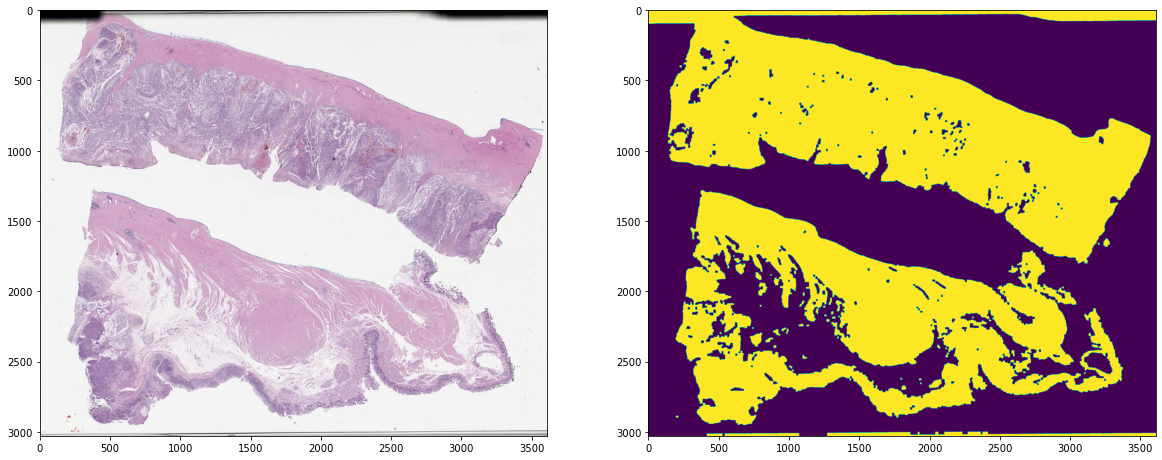

In [21]:
tissue_mask = get_otsu_mask(wsi_array)

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(wsi_array)
plt.subplot(122)
plt.imshow(tissue_mask)
plt.show()

In [22]:
tissue_kernel_1 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
tissue_kernel_2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# YUV 영상을 통한 thresholding
def get_otsu_mask(_img): # 파라미터 수정
    _, _, v = cv2.split(cv2.cvtColor(_img, cv2.COLOR_RGB2YUV))
    v = cv2.medianBlur(v, 5)
    _, _mask = cv2.threshold(v, -1, 255, cv2.THRESH_OTSU) # Otsu thresholding
    # 모폴로지 연산 (Open, Close)
    _mask = cv2.morphologyEx(_mask, cv2.MORPH_OPEN, tissue_kernel_1, iterations=2)
    _mask = cv2.morphologyEx(_mask, cv2.MORPH_CLOSE, tissue_kernel_1, iterations=2)
    _mask = cv2.morphologyEx(_mask, cv2.MORPH_OPEN, tissue_kernel_1, iterations=5)
    _mask = cv2.morphologyEx(_mask, cv2.MORPH_CLOSE, tissue_kernel_1, iterations=5)
    return _mask

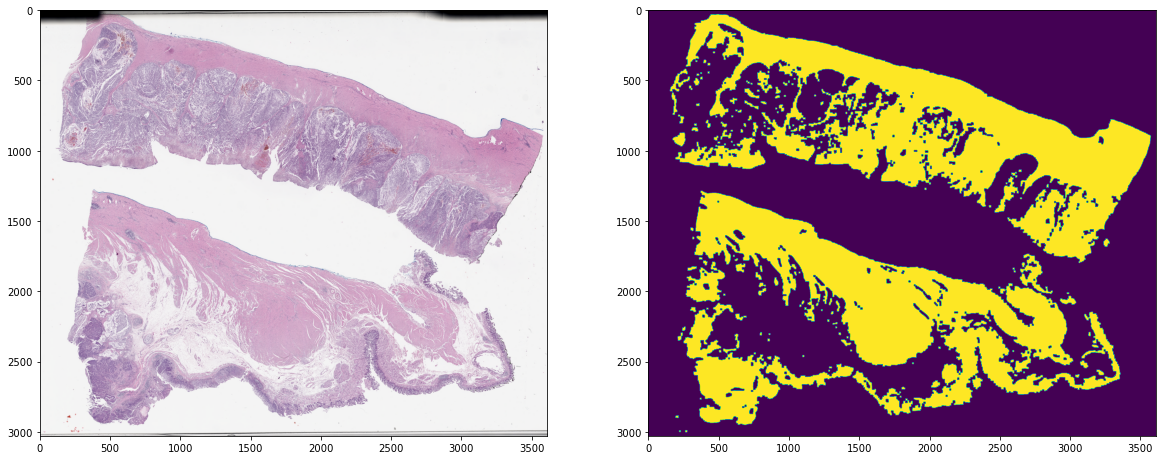

In [23]:
tissue_mask = get_otsu_mask(wsi_array)

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(wsi_array)
plt.subplot(122)
plt.imshow(tissue_mask)
plt.show()

##### ex) background patch

In [41]:
TISSUE_AREA_RATIO = 0.0

def is_inside_tissue(_mask):
    tissue_area = np.sum(_mask) // 255
    mask_area = np.prod(PATCH_SIZE)
    return (tissue_area / mask_area) > TISSUE_AREA_RATIO

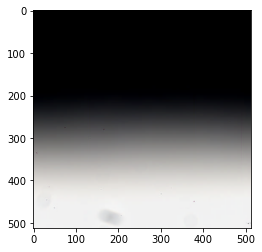

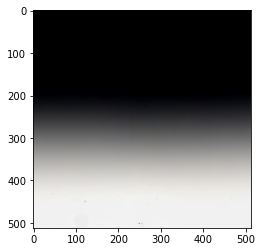

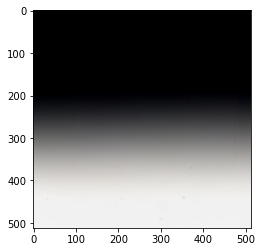

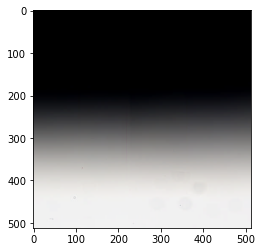

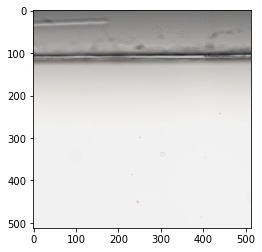

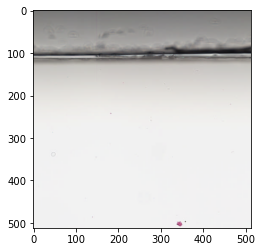

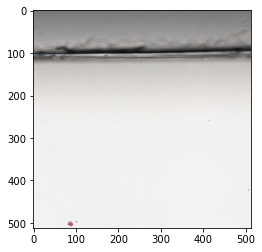

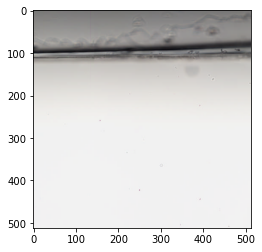

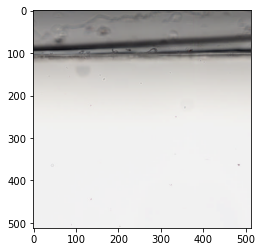

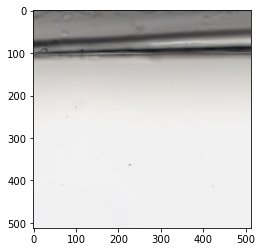

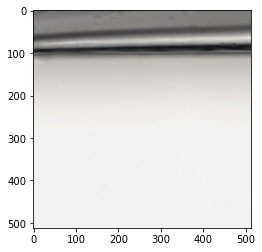

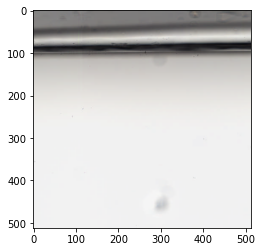

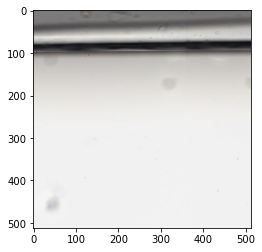

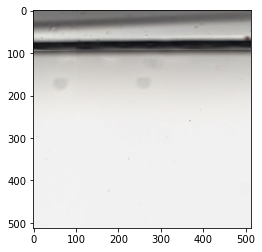

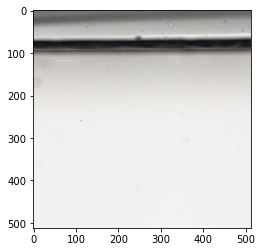

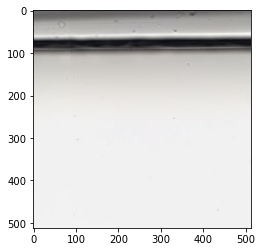

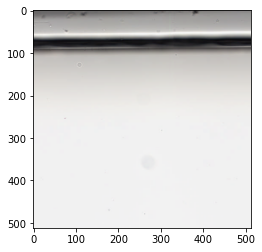

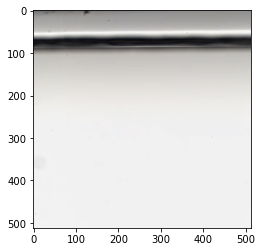

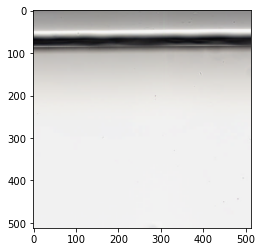

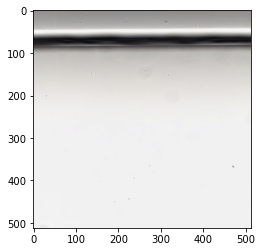

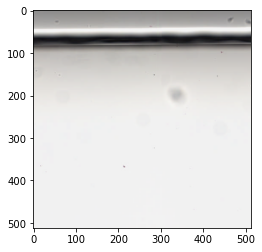

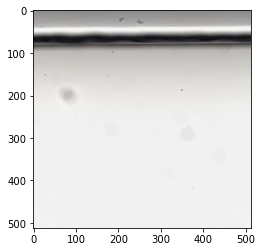

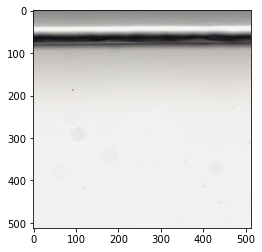

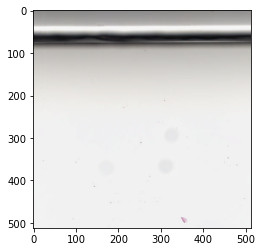

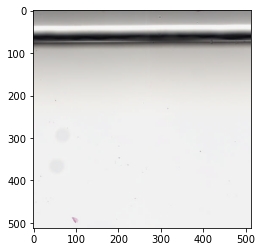

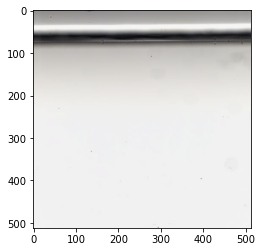

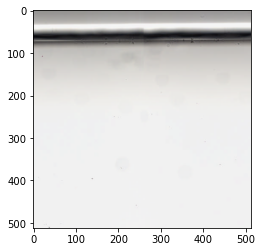

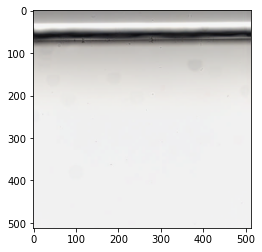

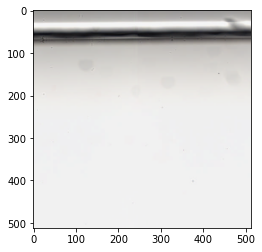

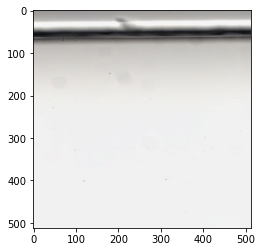

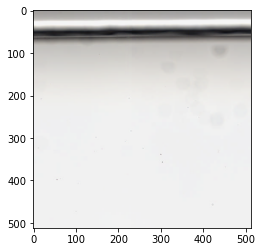

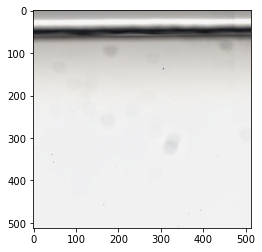

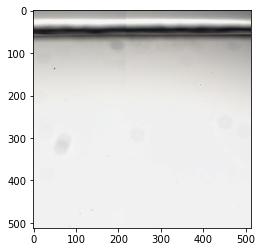

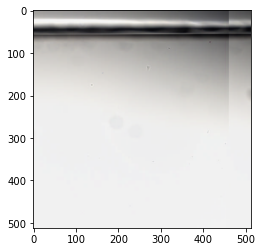

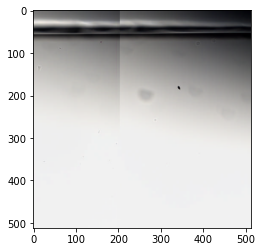

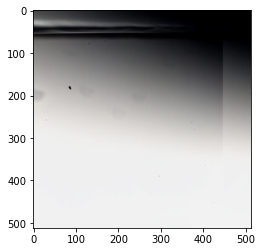

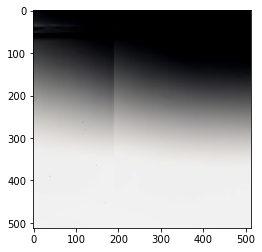

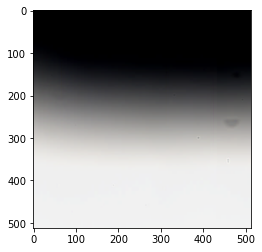

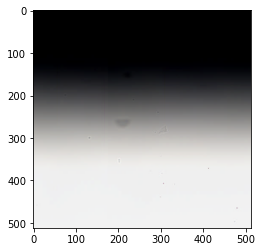

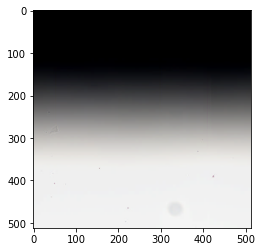

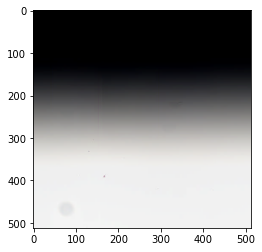

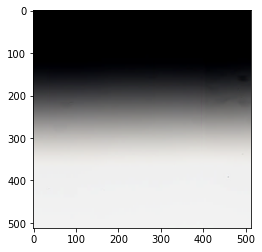

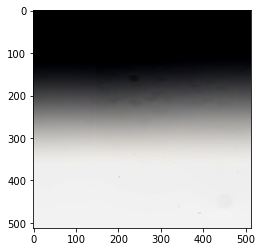

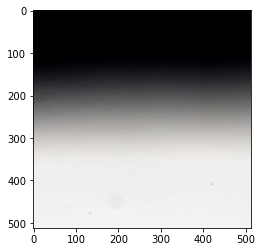

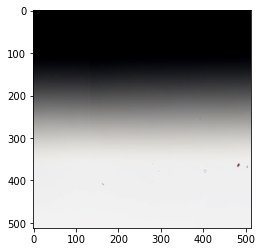

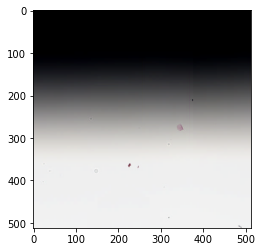

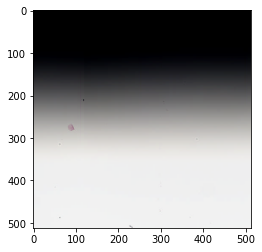

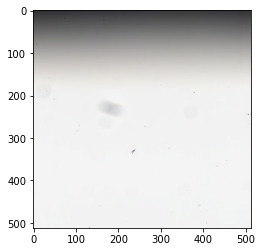

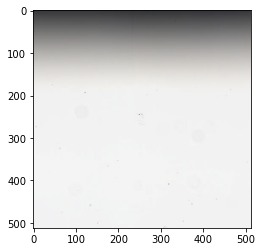

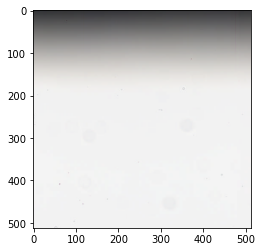

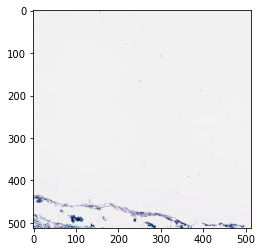

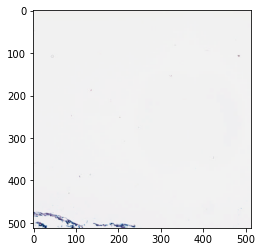

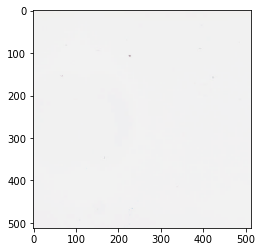

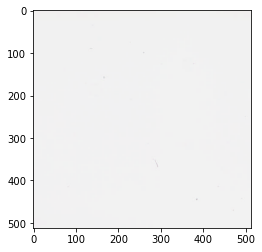

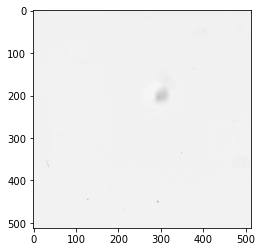

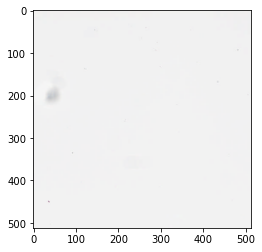

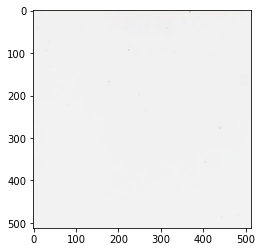

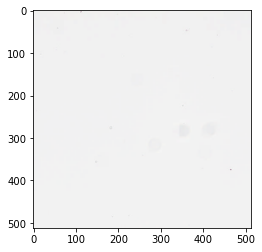

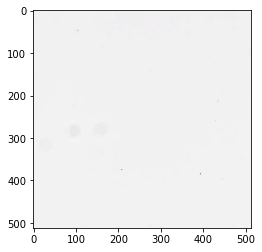

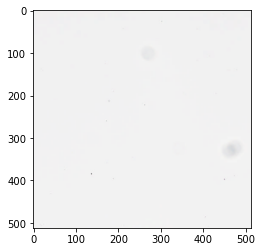

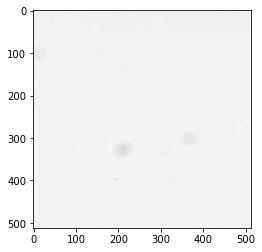

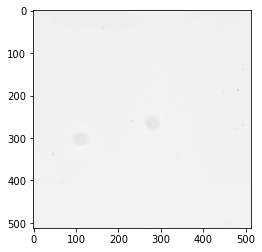

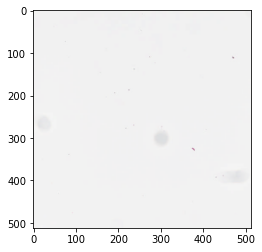

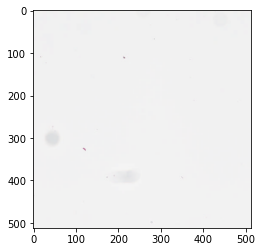

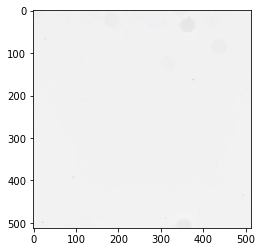

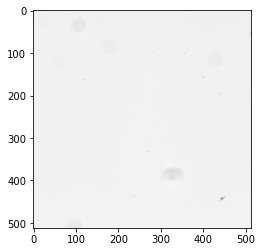

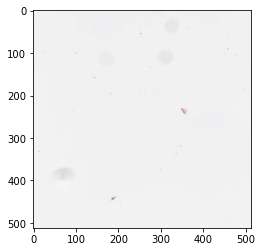

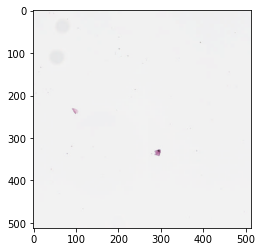

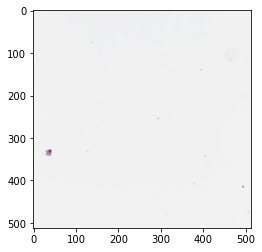

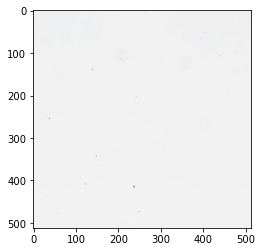

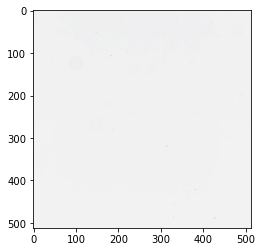

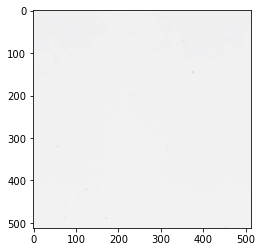

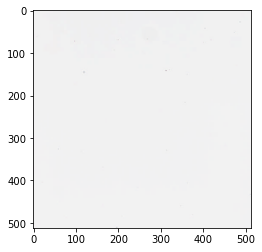

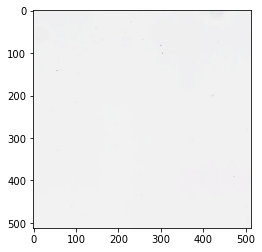

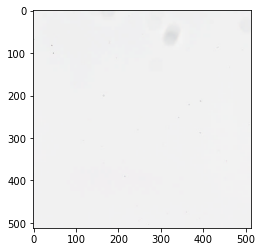

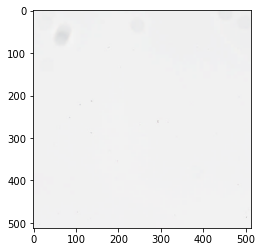

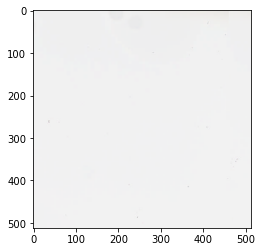

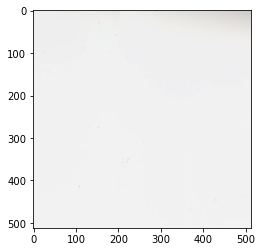

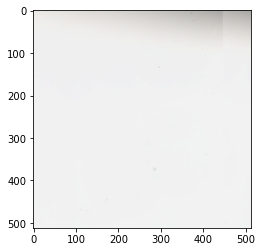

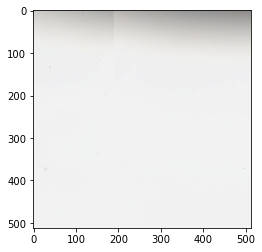

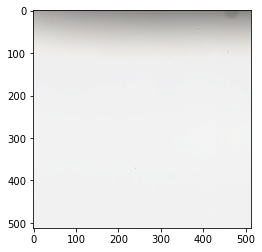

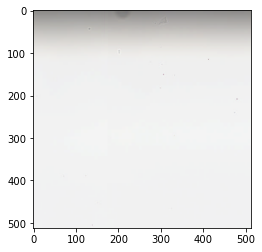

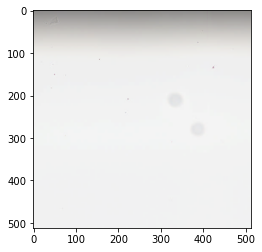

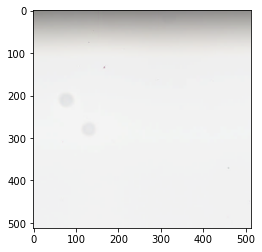

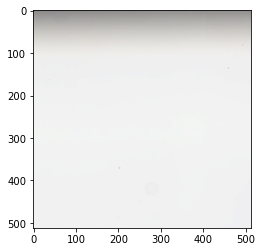

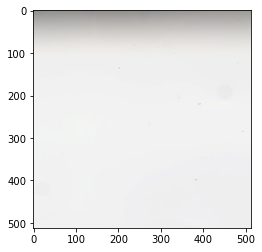

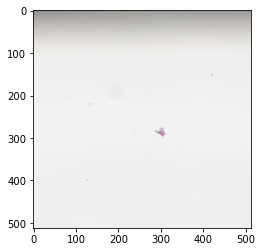

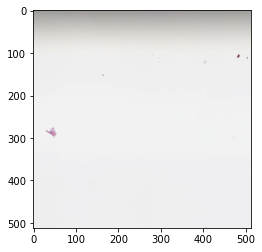

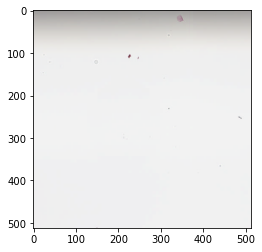

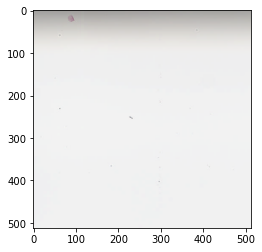

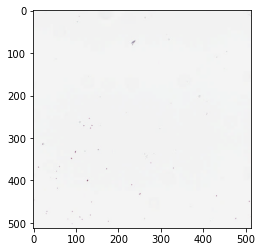

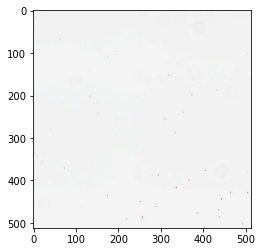

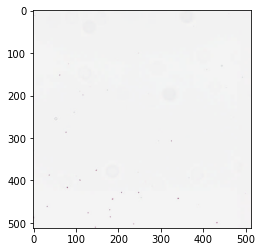

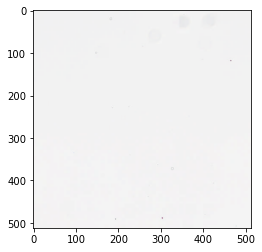

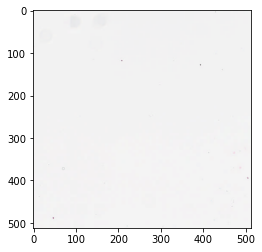

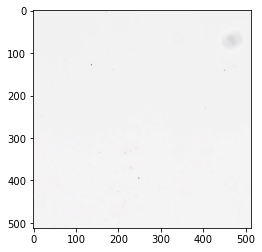

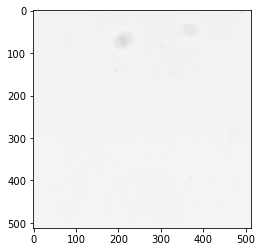

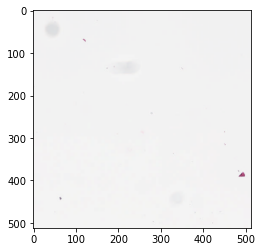

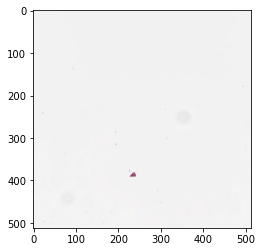

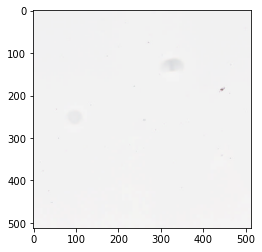

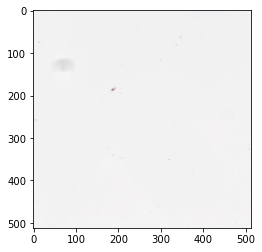

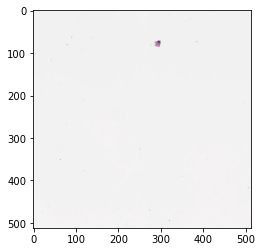

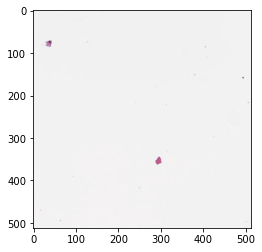

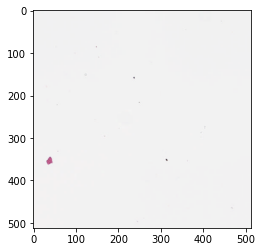

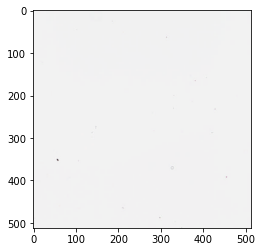

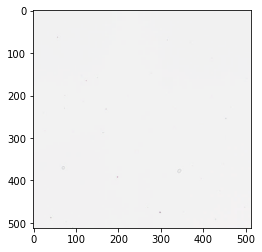

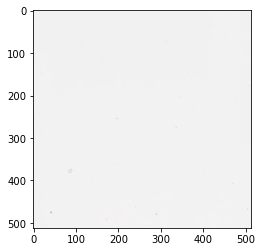

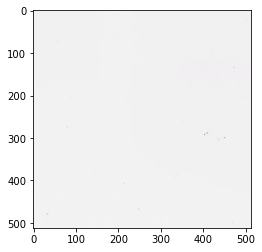

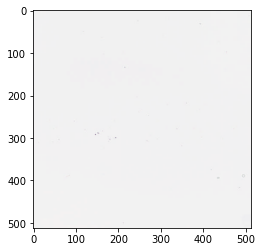

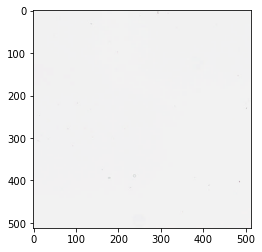

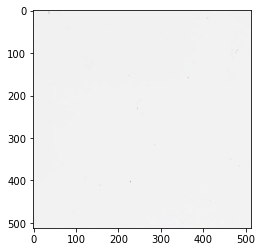

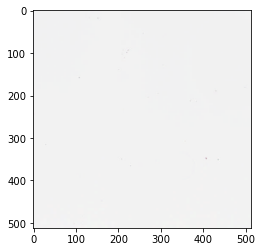

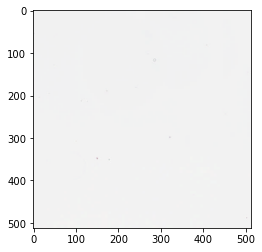

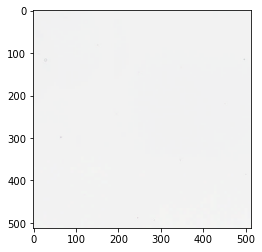

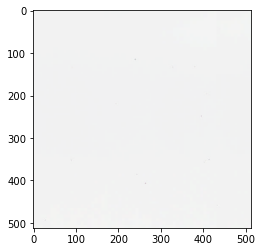

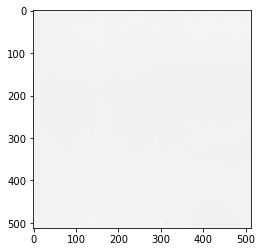

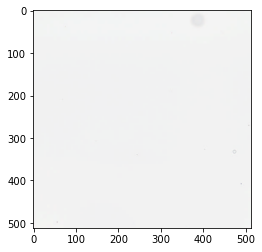

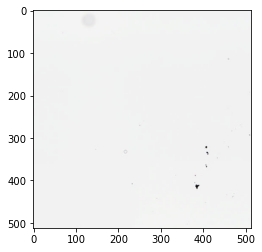

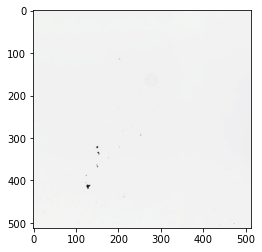

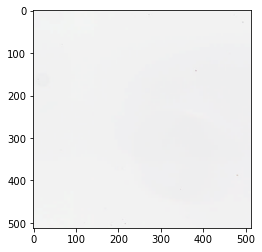

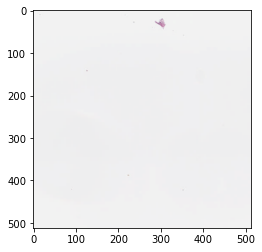

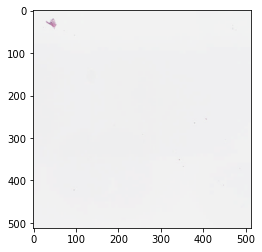

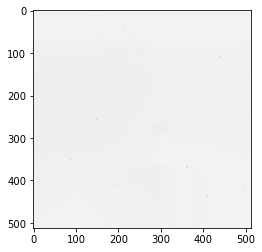

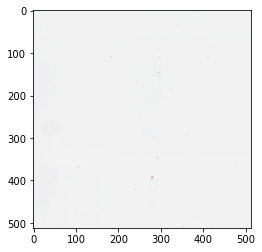

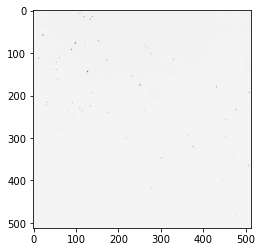

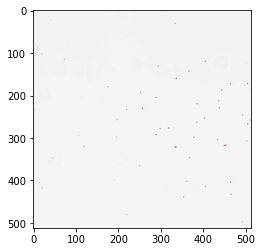

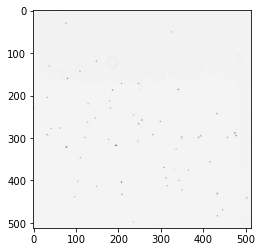

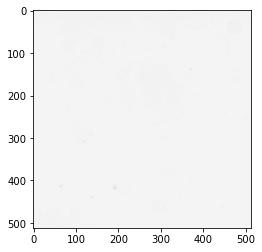

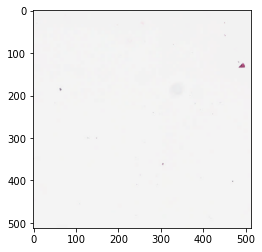

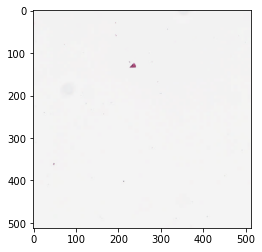

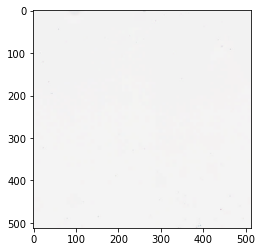

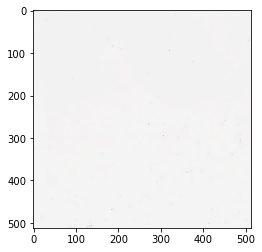

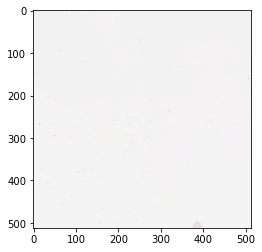

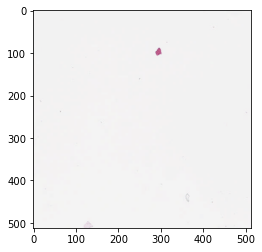

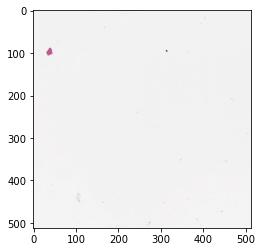

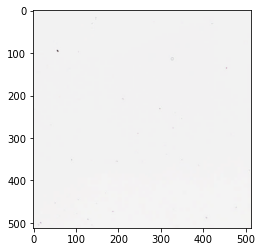

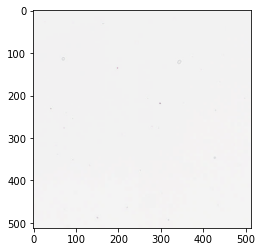

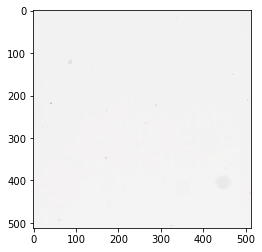

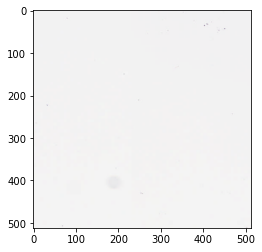

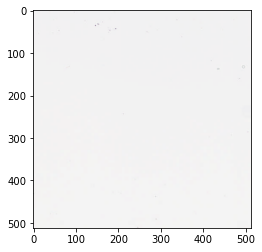

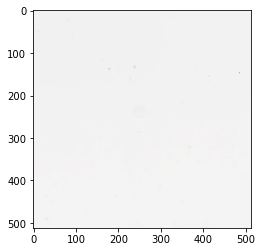

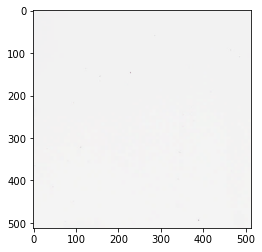

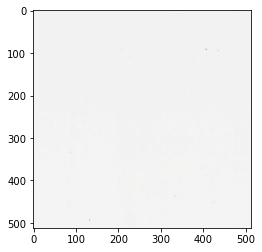

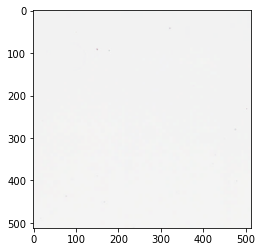

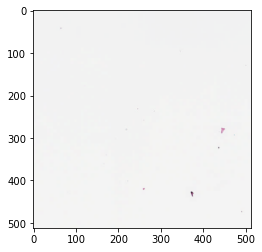

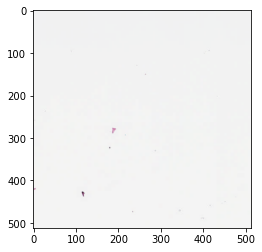

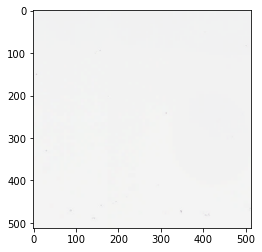

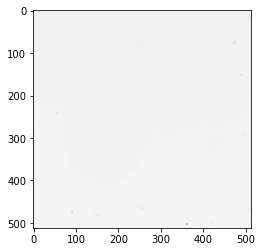

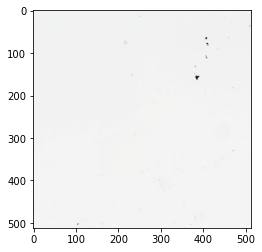

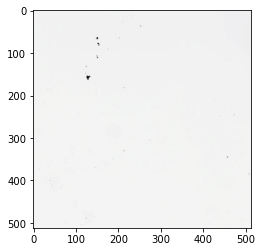

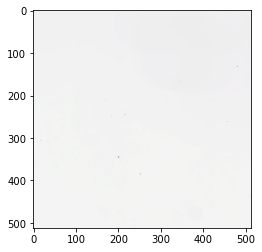

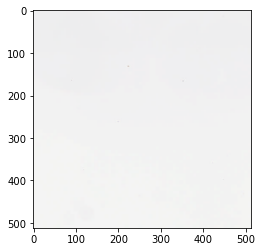

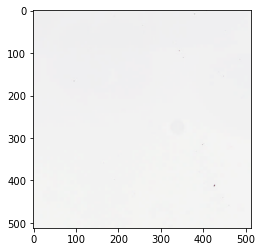

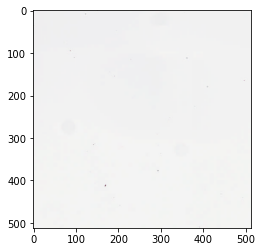

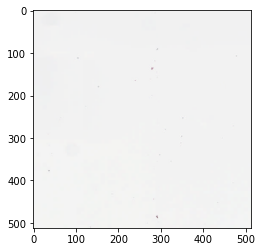

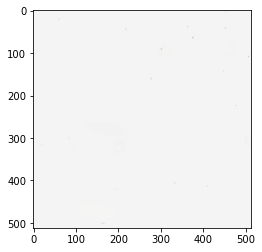

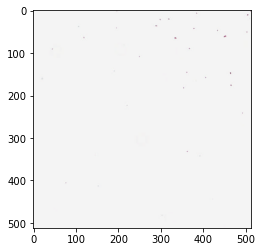

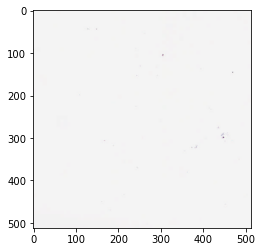

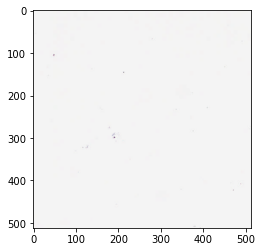

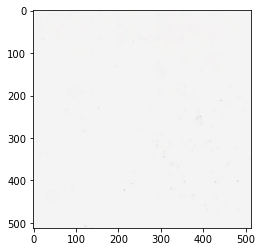

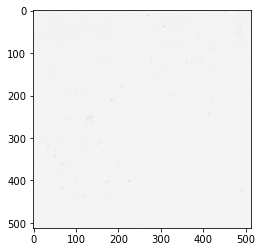

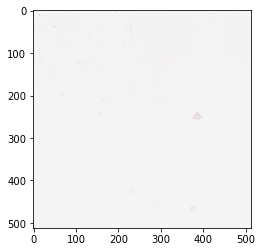

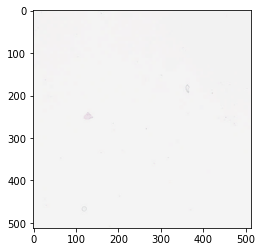

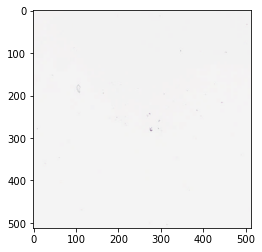

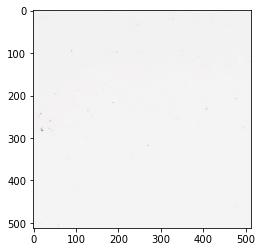

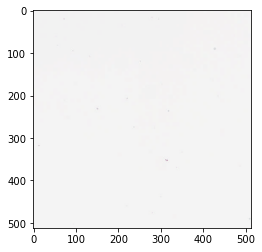

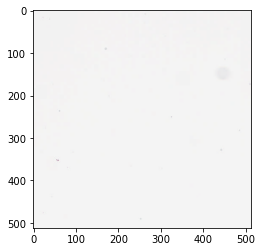

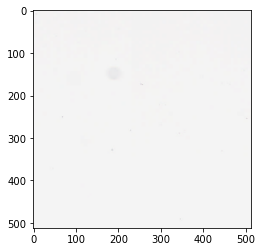

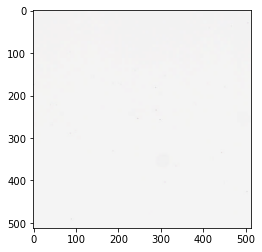

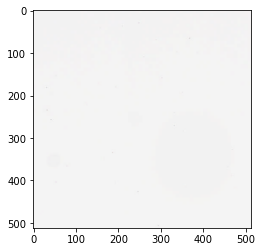

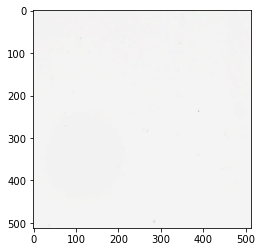

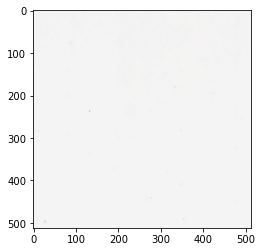

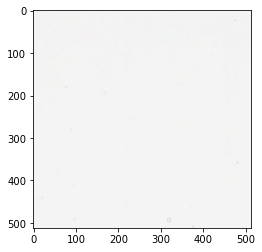

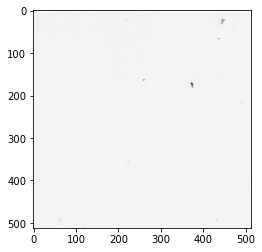

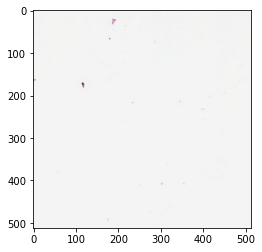

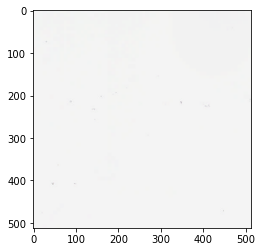

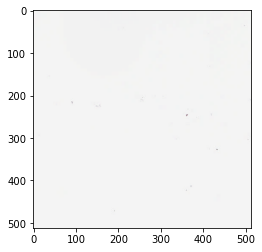

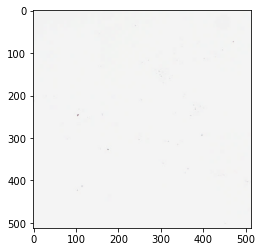

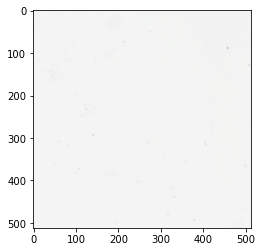

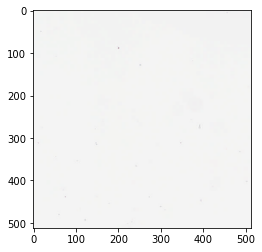

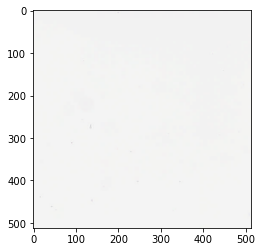

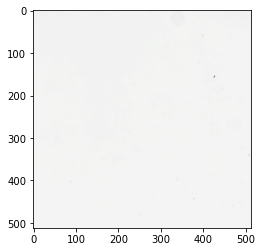

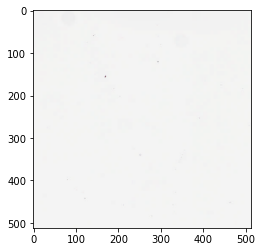

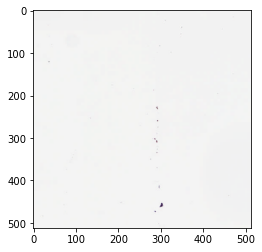

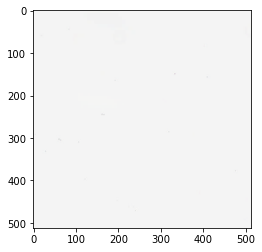

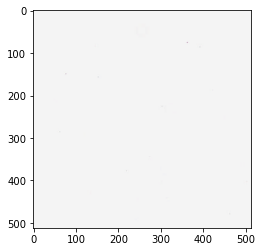

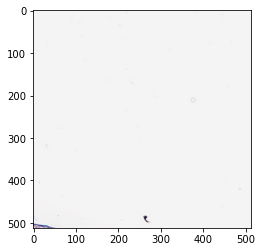

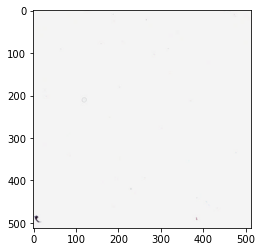

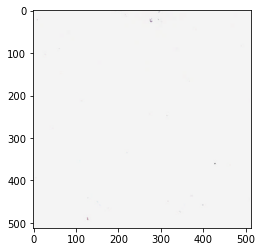

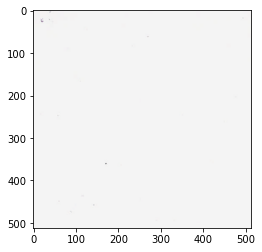

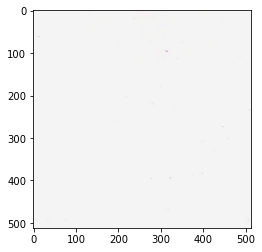

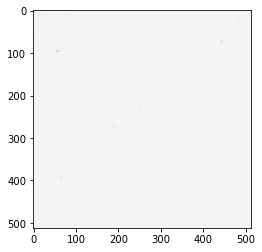

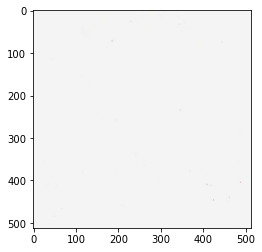

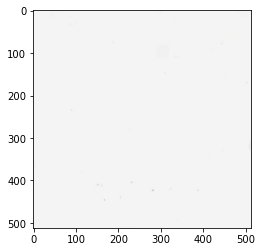

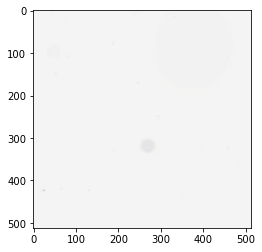

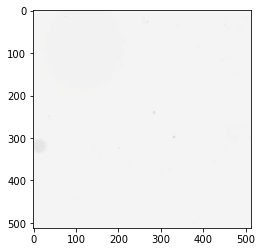

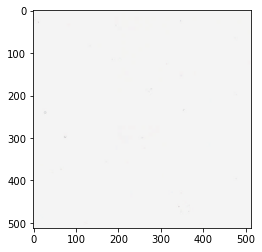

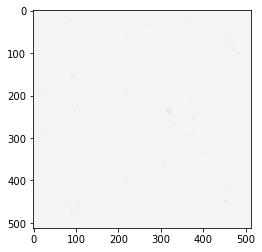

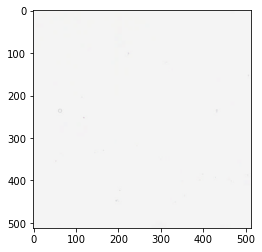

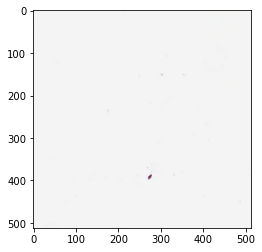

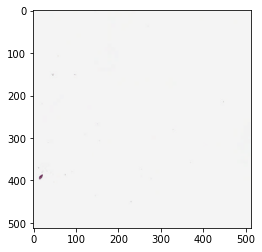

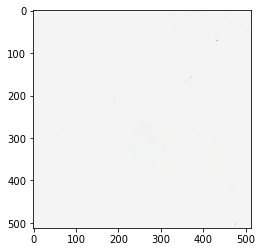

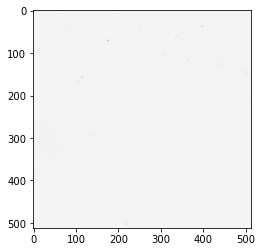

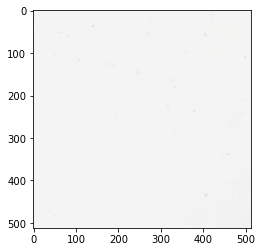

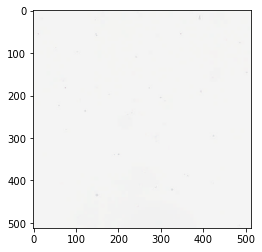

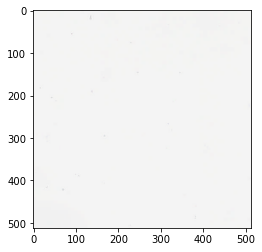

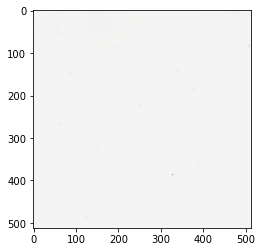

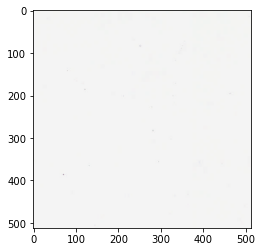

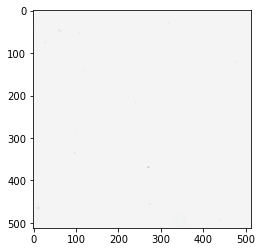

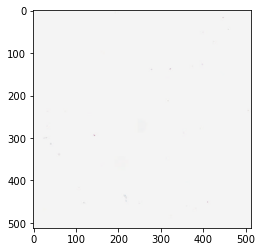

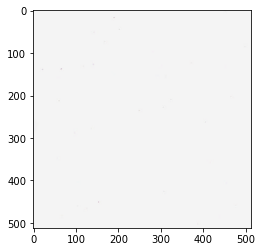

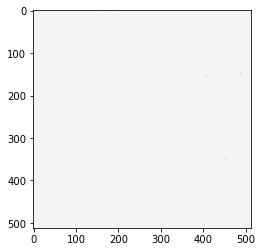

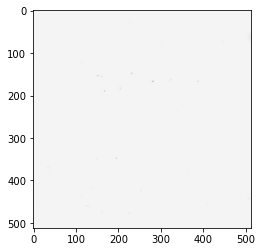

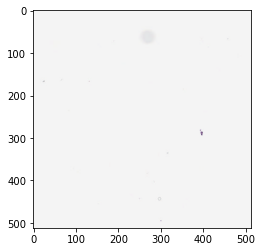

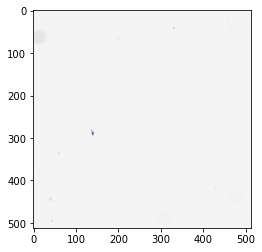

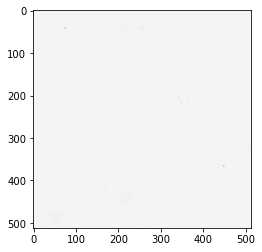

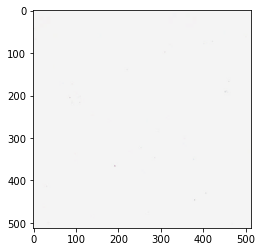

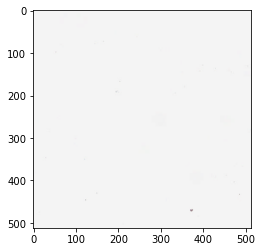

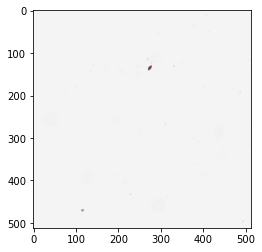

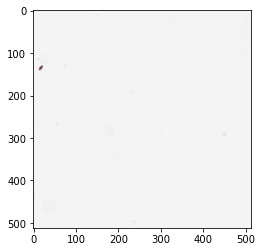

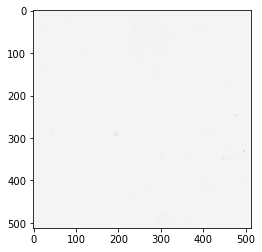

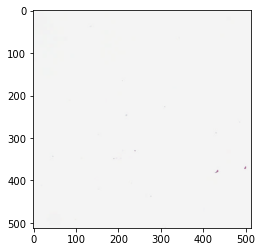

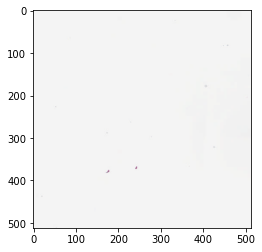

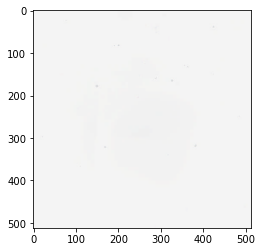

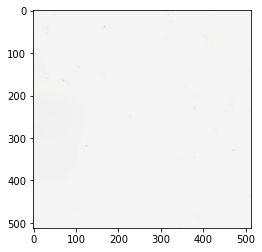

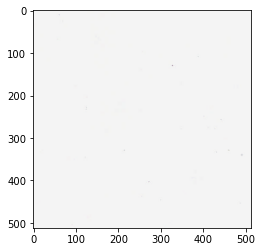

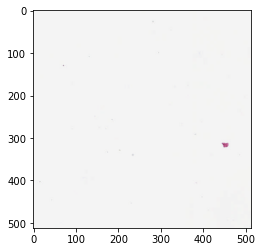

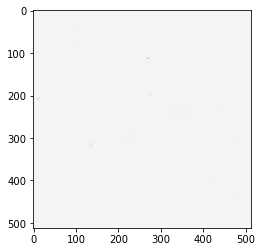

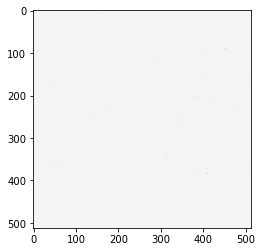

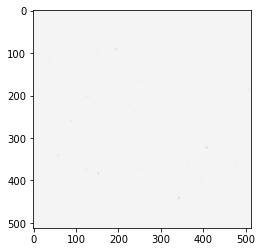

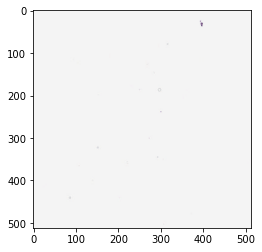

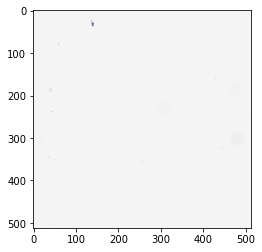

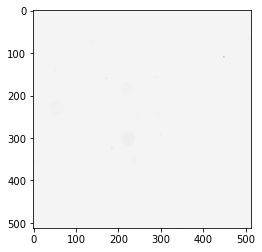

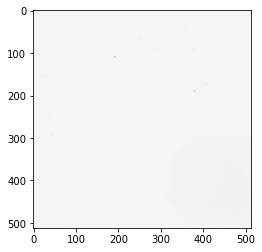

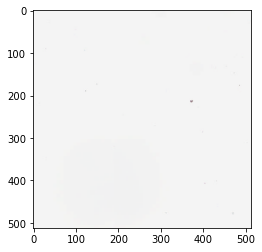

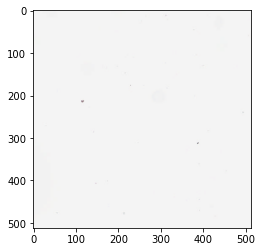

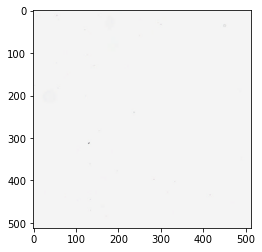

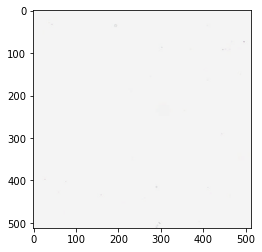

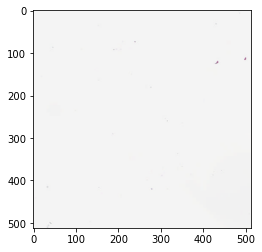

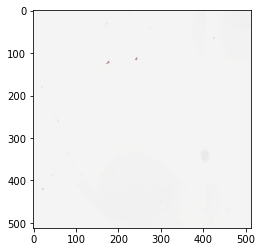

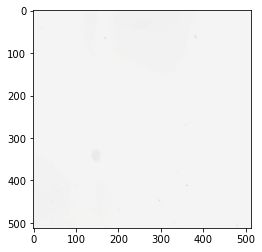

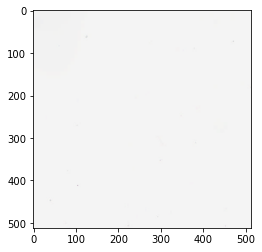

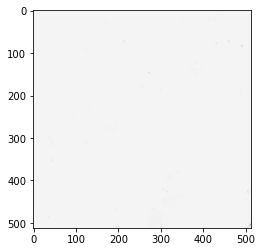

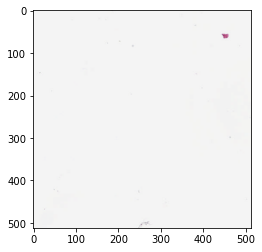

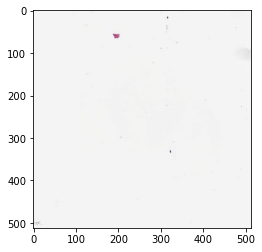

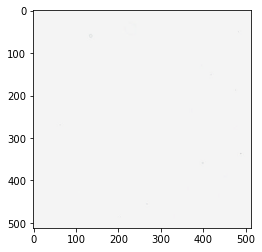

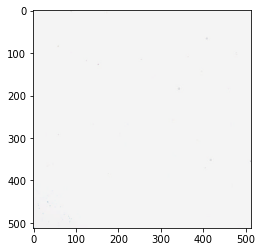

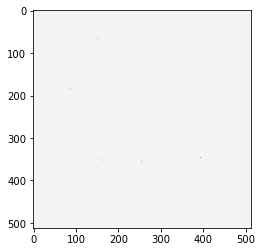

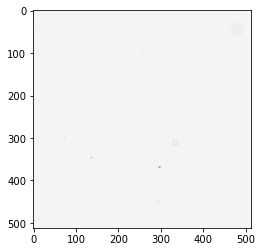

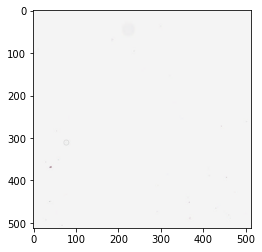

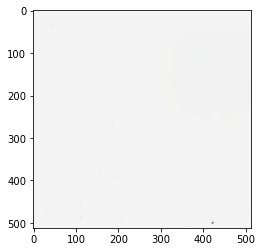

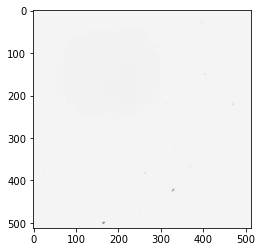

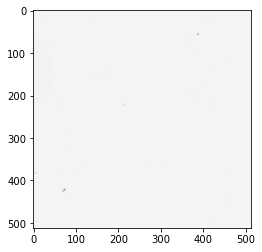

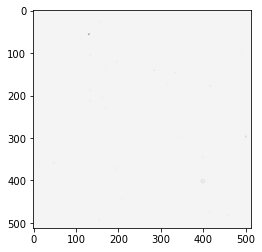

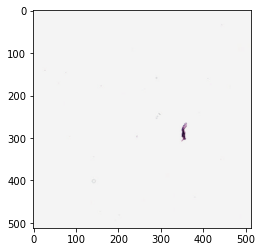

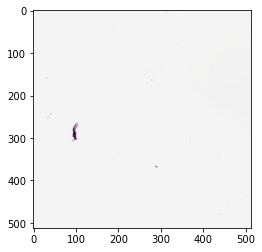

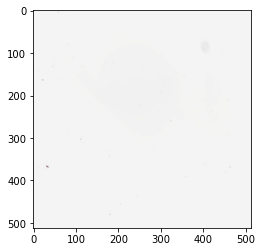

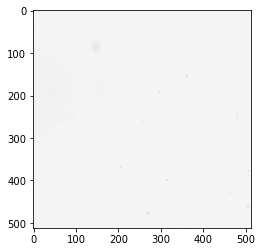

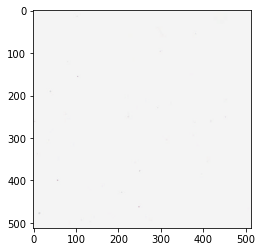

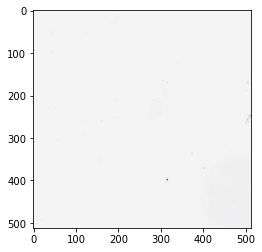

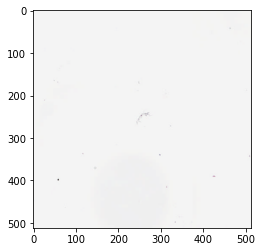

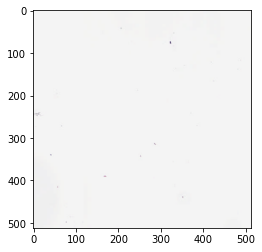

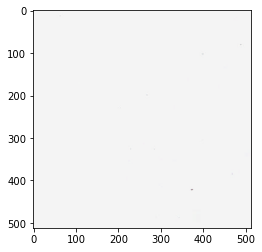

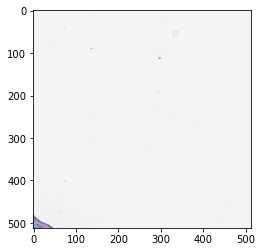

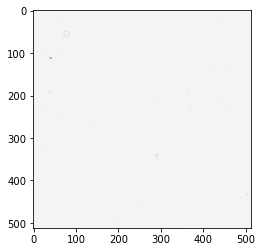

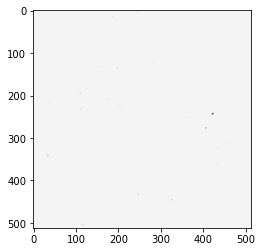

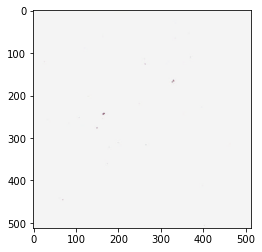

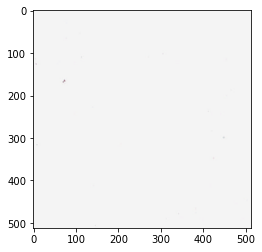

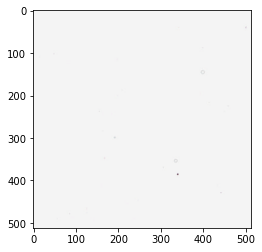

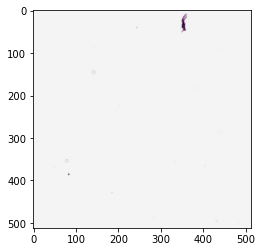

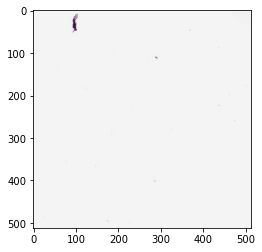

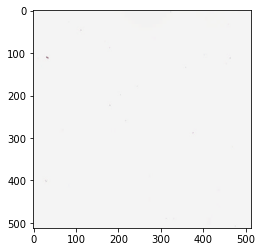

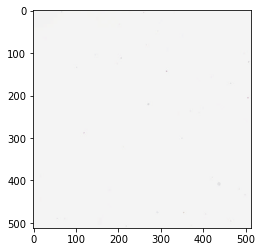

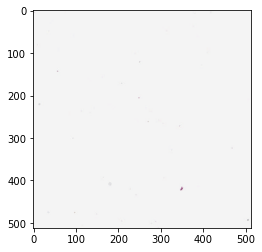

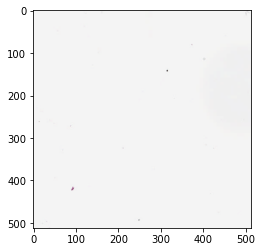

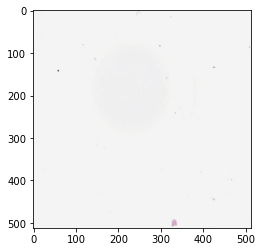

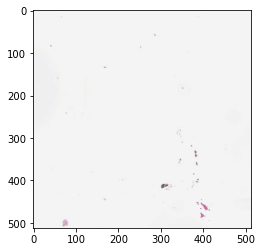

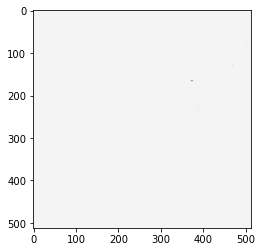

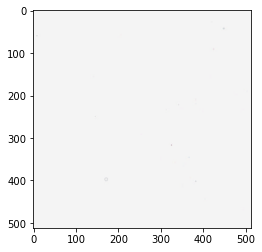

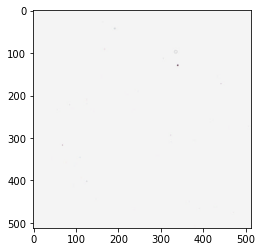

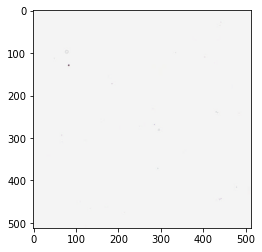

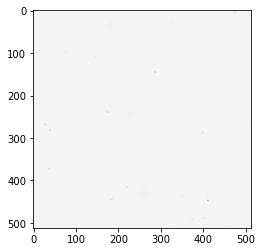

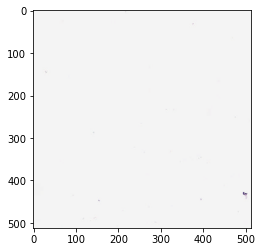

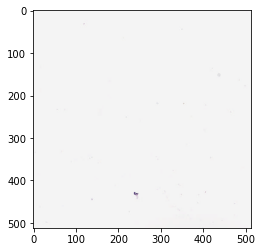

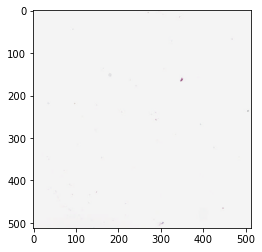

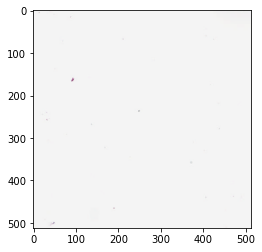

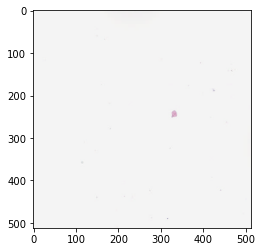

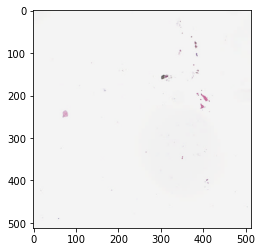

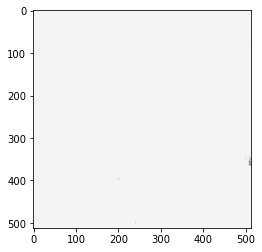

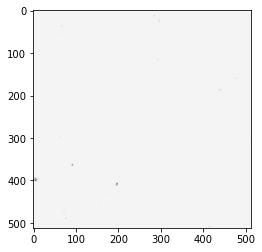

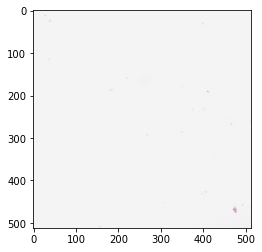

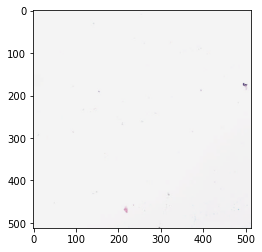

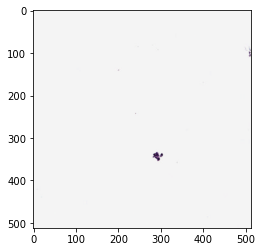

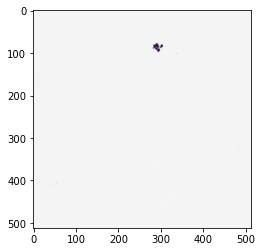

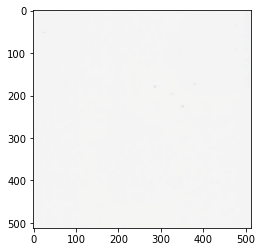

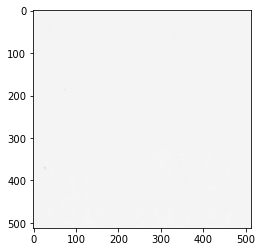

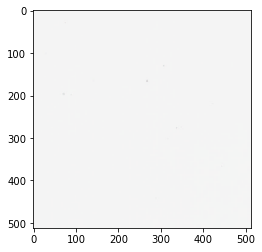

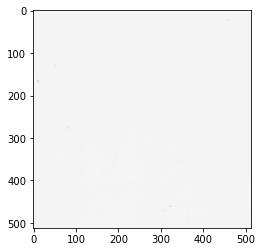

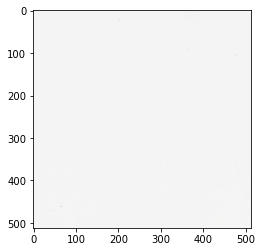

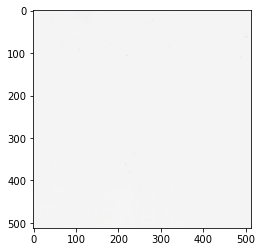

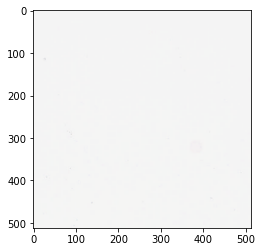

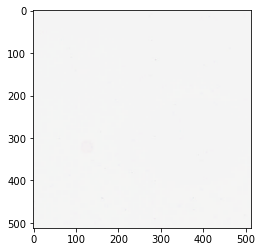

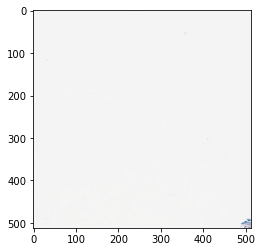

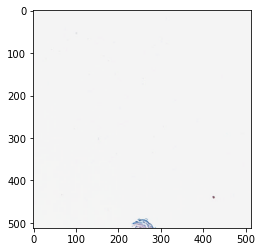

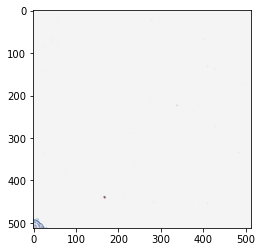

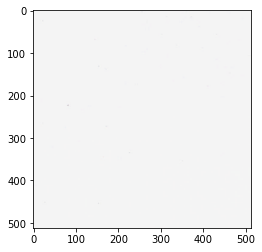

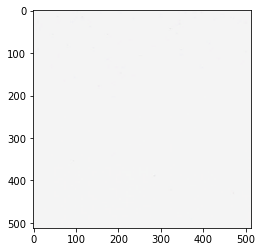

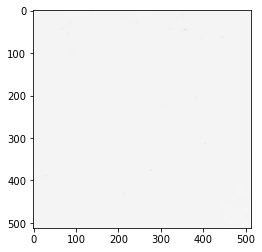

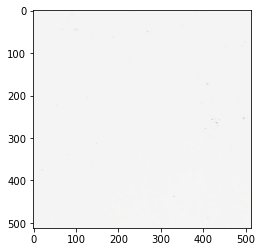

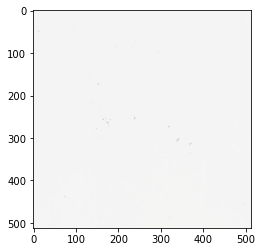

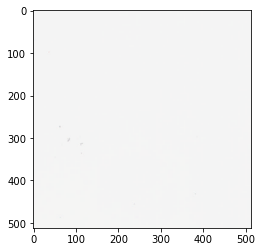

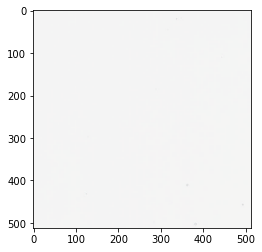

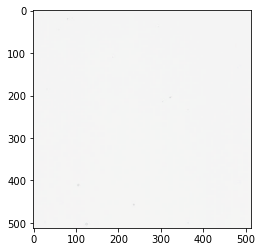

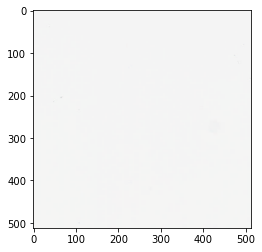

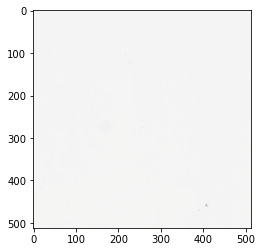

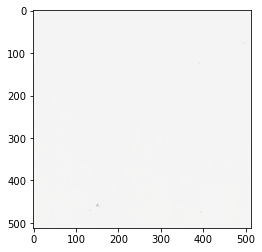

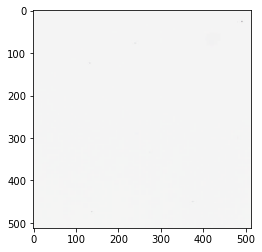

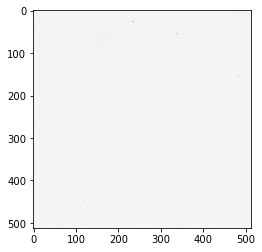

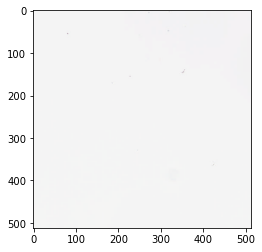

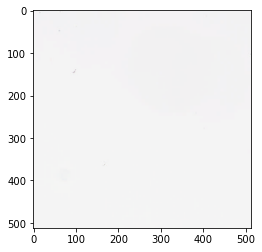

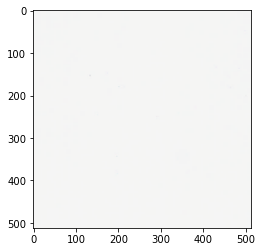

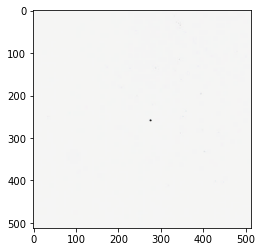

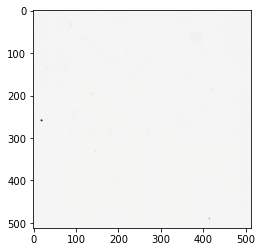

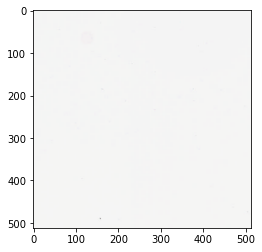

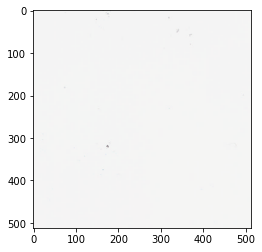

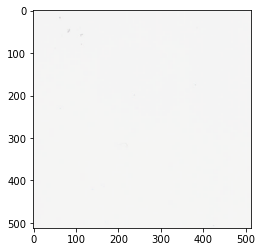

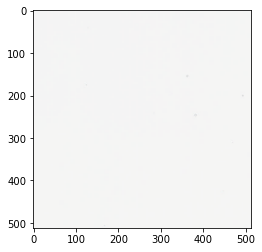

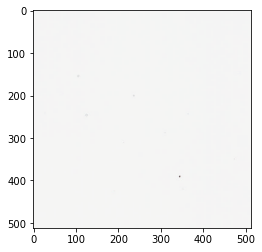

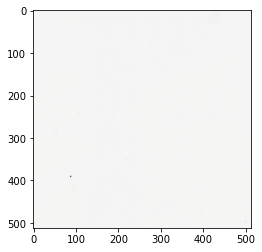

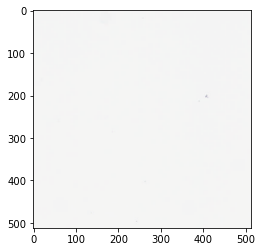

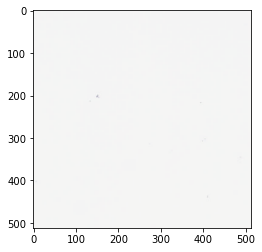

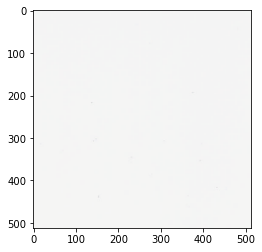

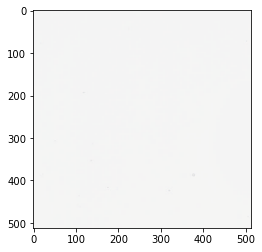

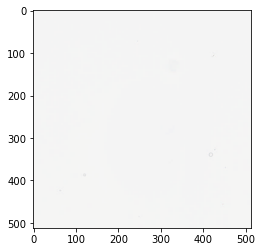

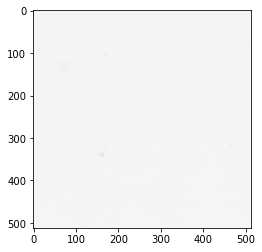

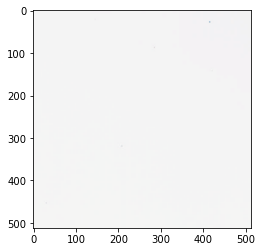

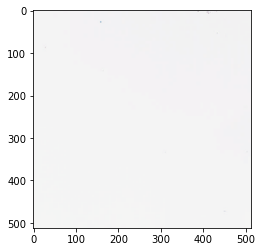

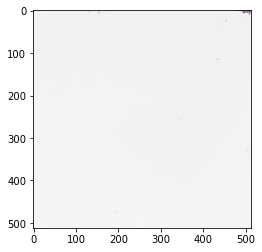

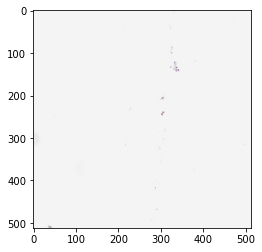

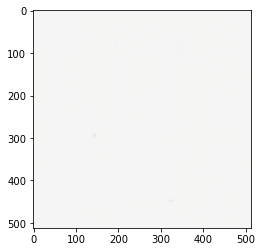

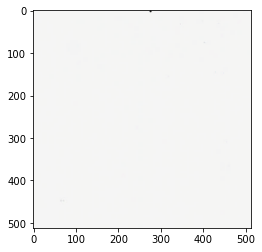

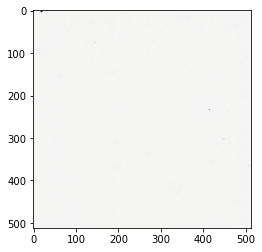

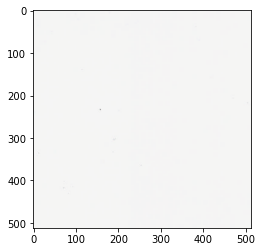

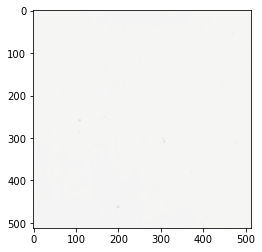

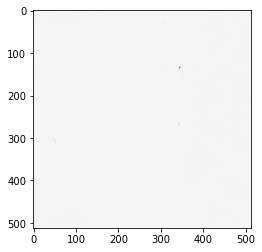

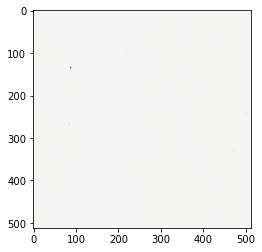

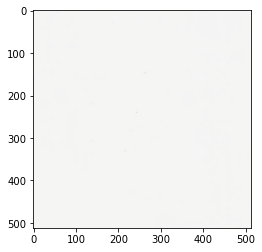

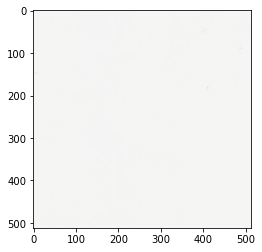

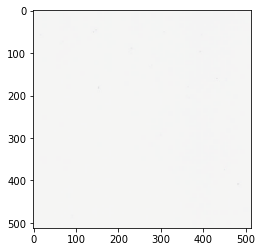

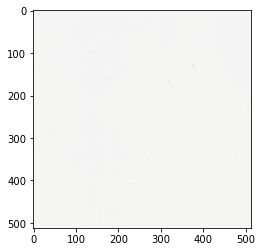

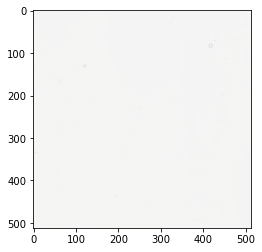

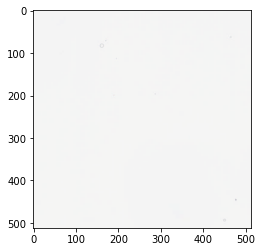

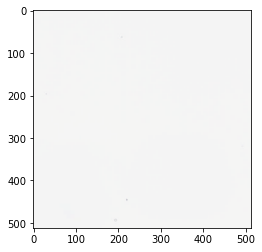

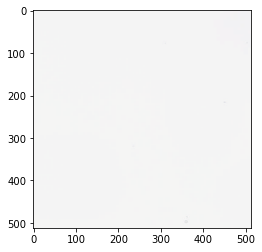

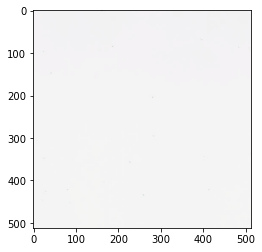

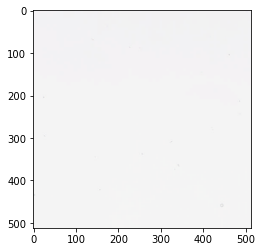

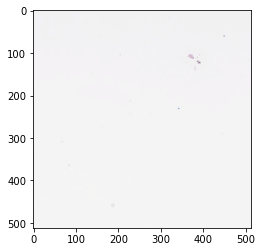

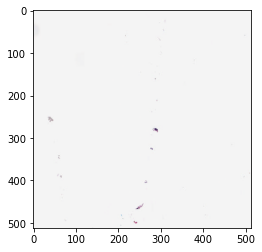

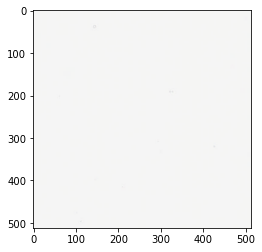

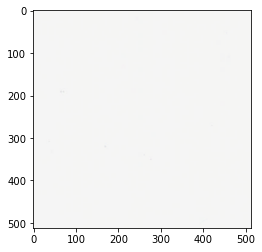

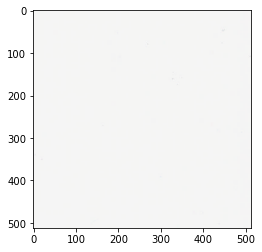

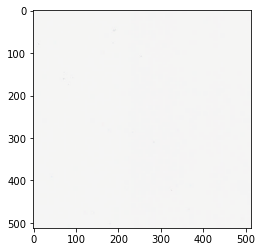

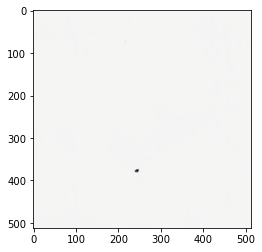

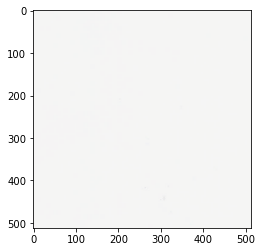

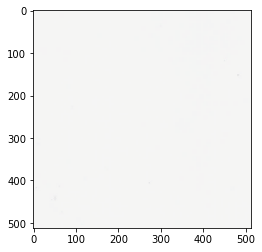

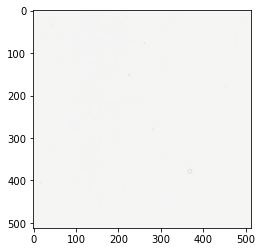

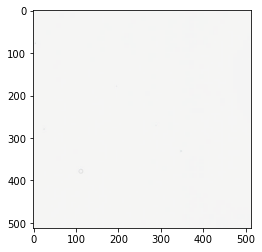

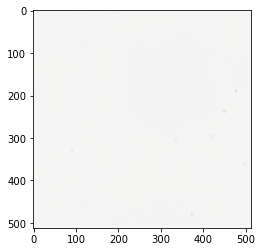

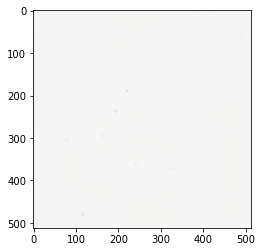

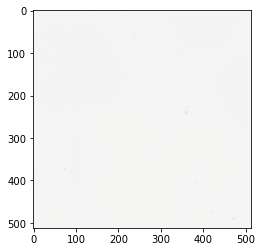

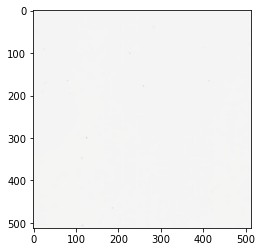

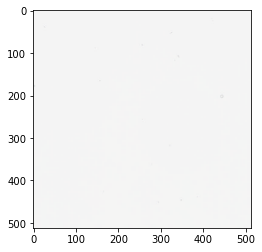

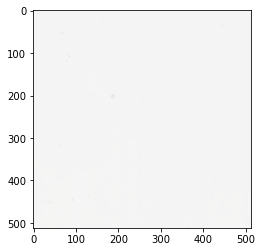

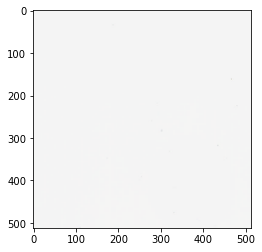

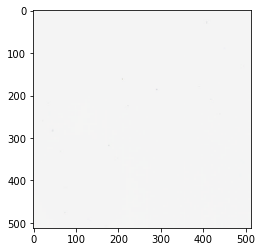

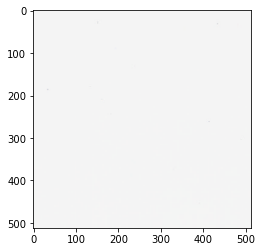

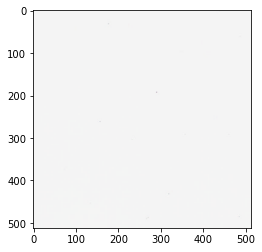

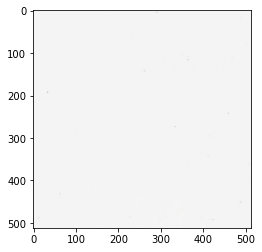

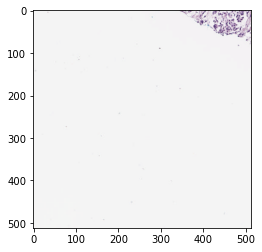

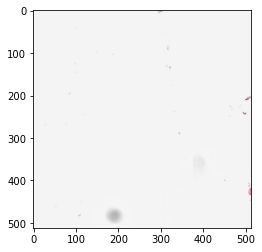

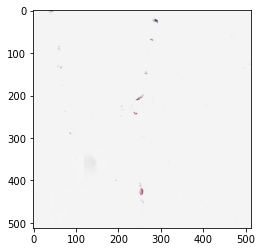

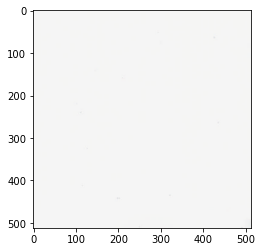

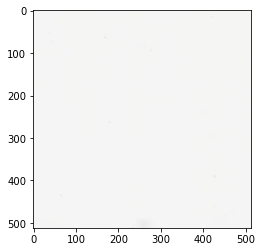

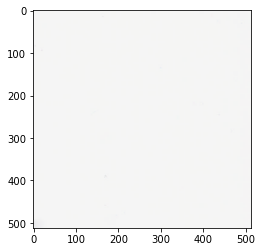

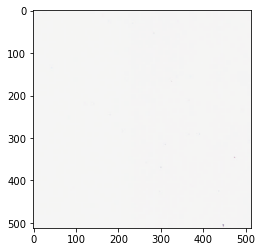

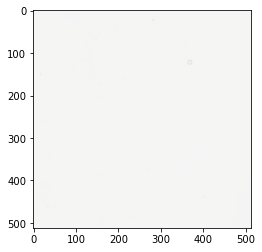

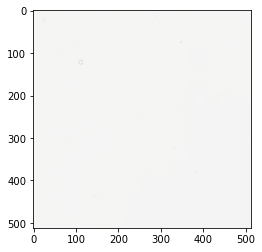

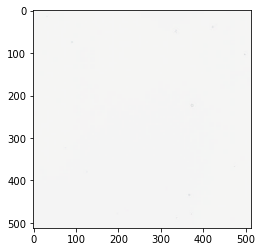

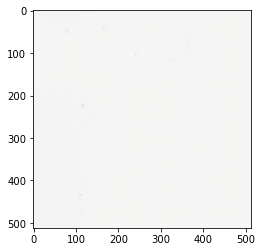

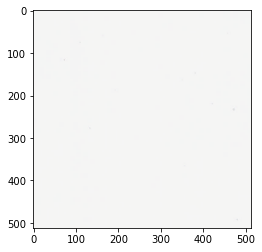

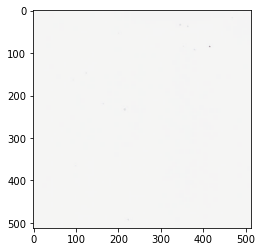

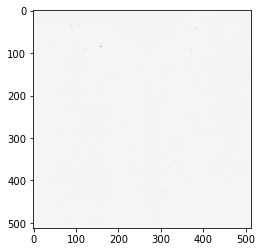

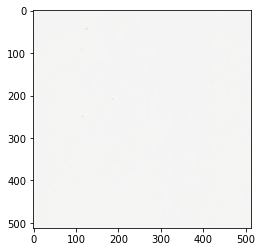

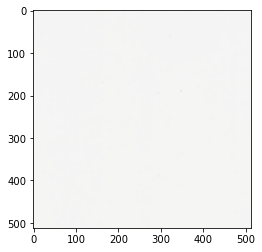

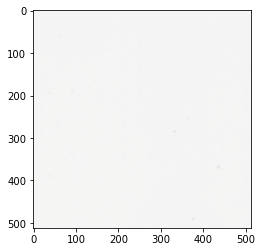

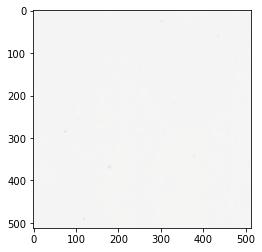

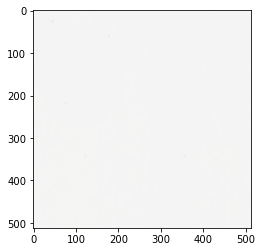

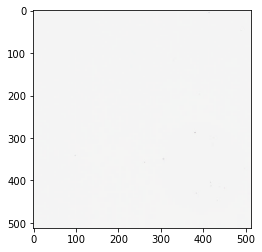

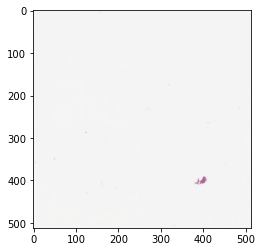

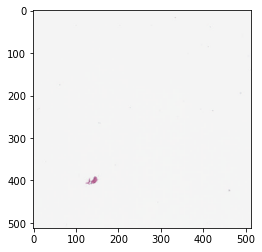

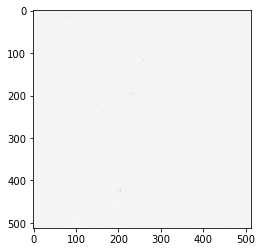

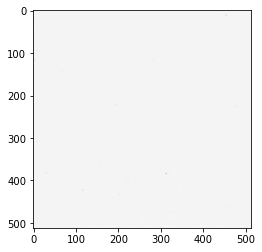

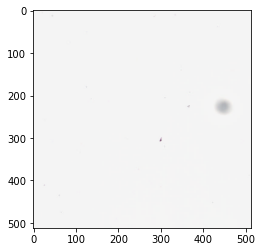

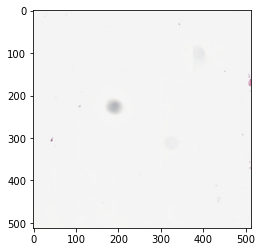

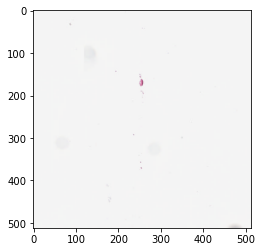

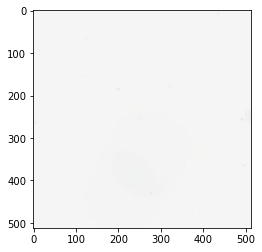

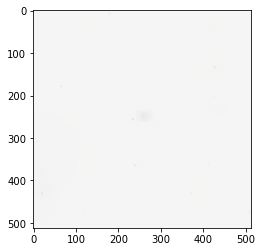

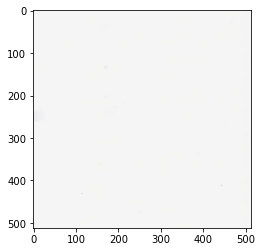

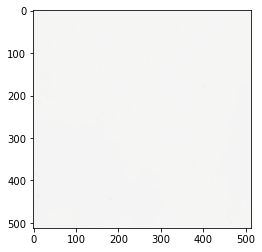

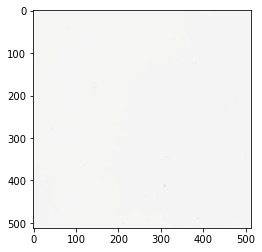

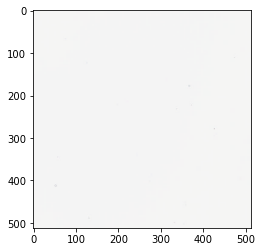

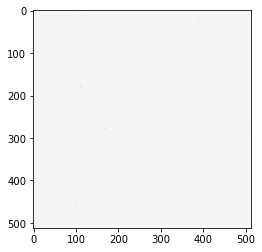

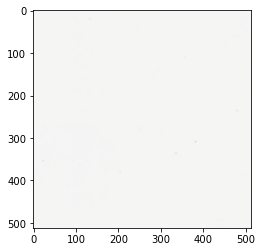

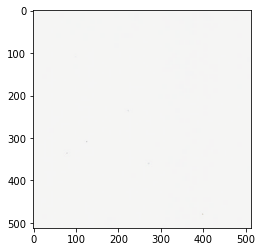

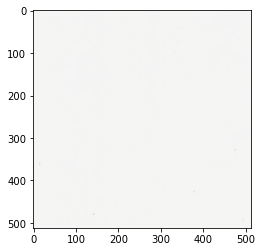

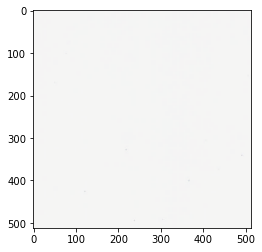

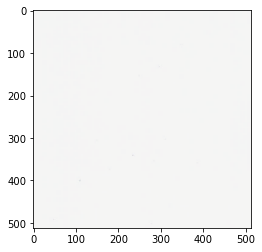

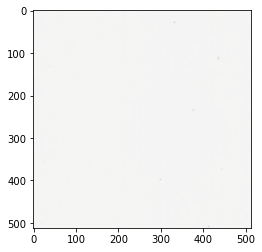

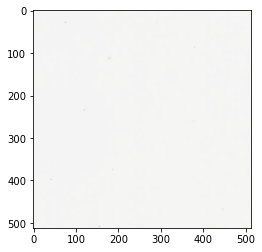

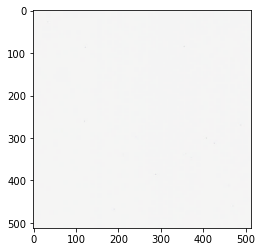

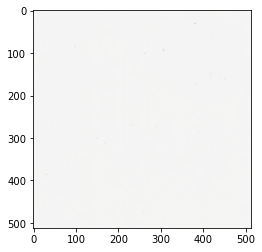

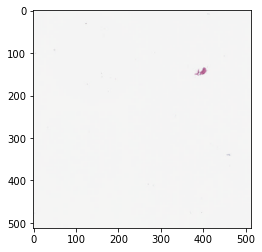

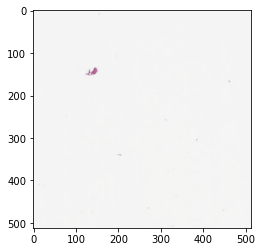

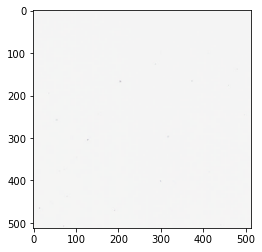

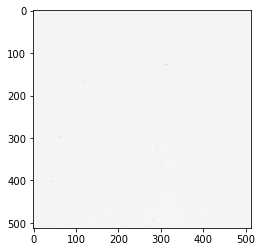

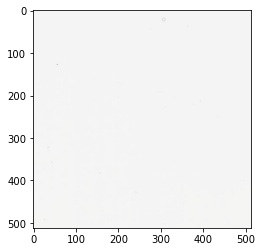

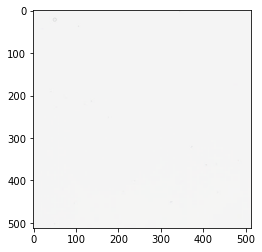

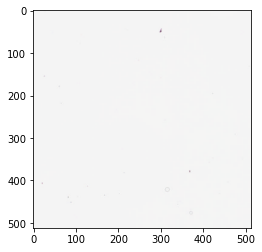

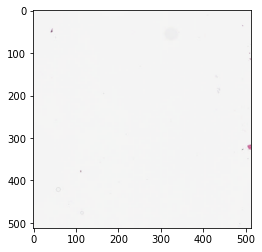

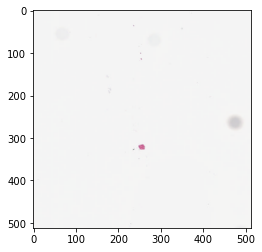

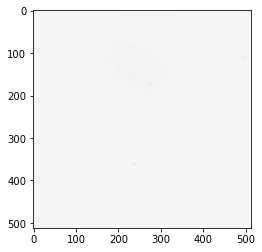

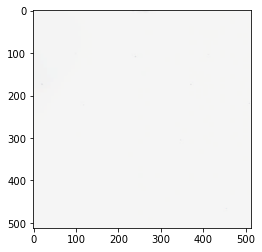

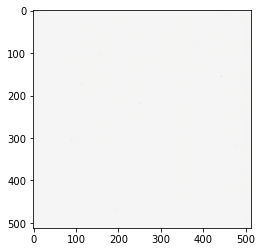

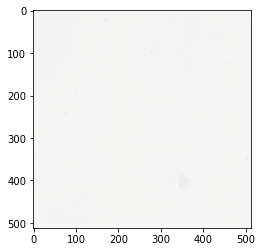

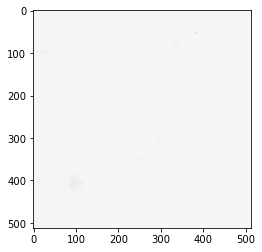

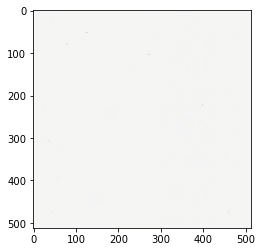

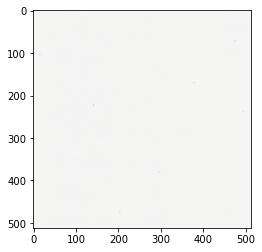

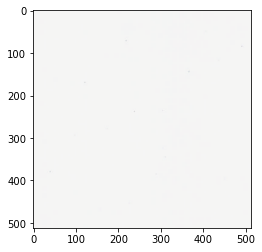

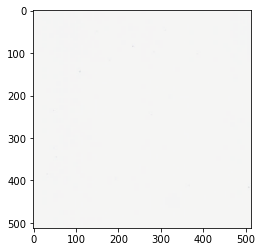

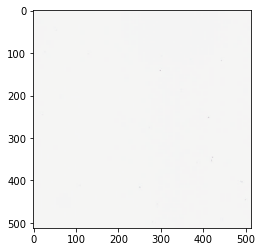

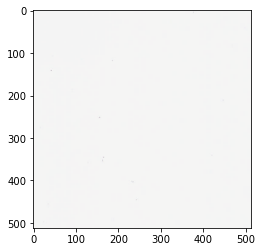

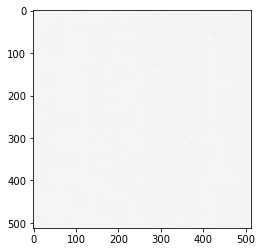

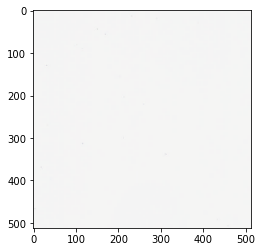

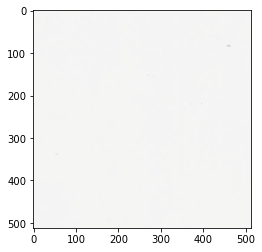

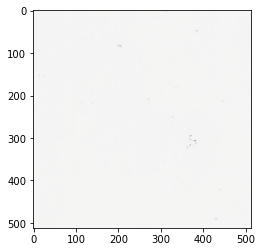

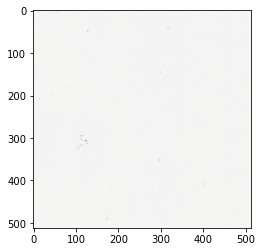

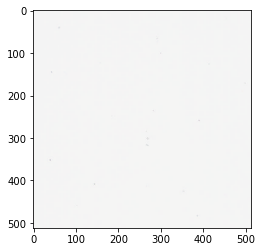

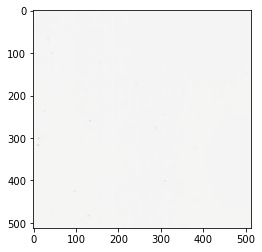

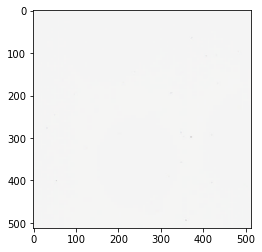

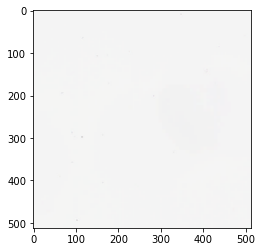

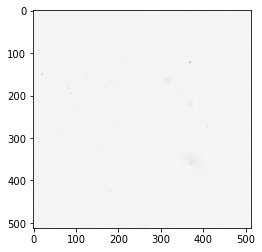

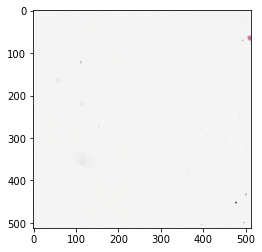

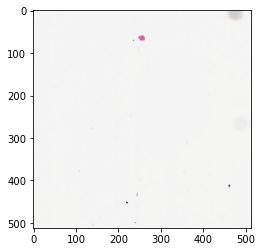

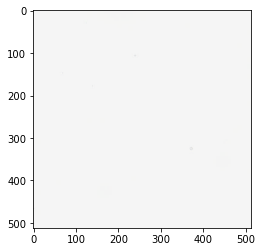

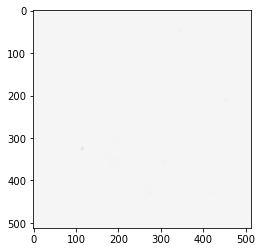

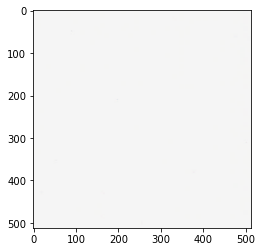

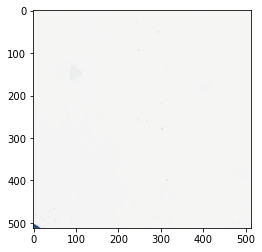

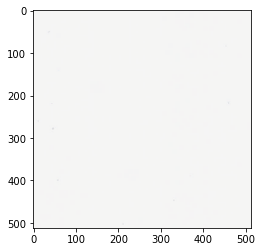

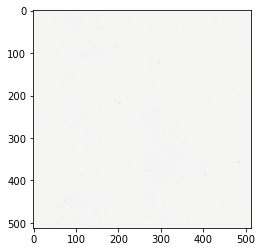

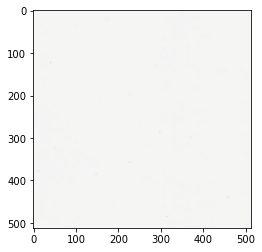

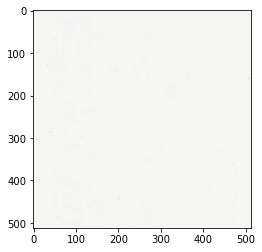

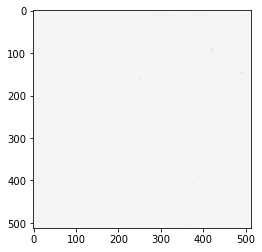

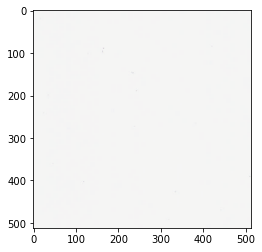

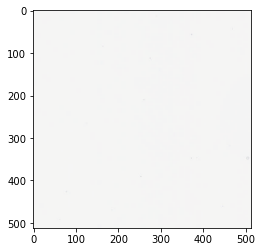

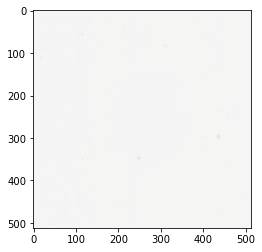

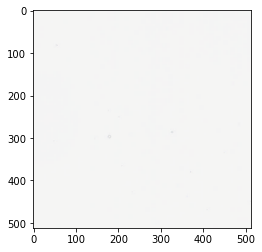

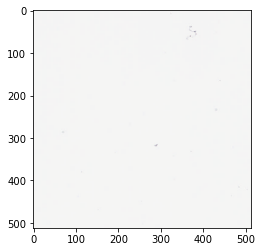

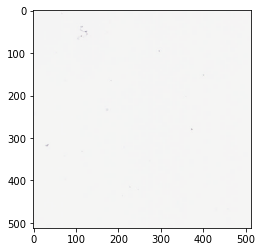

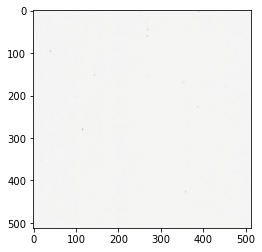

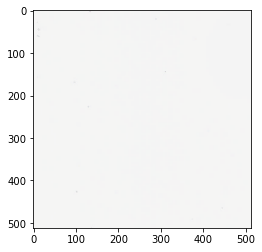

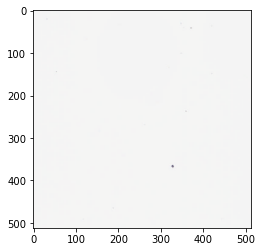

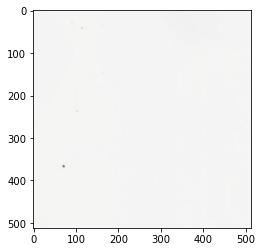

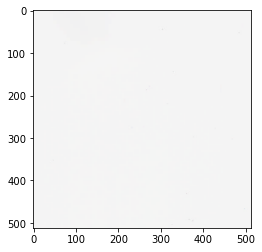

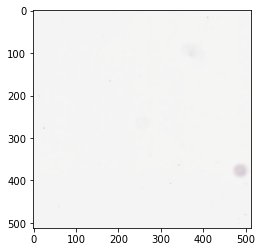

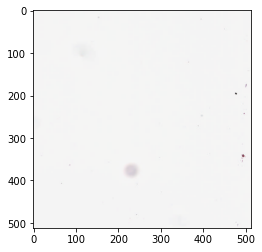

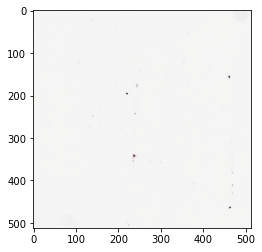

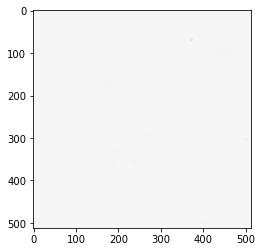

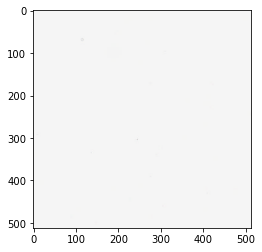

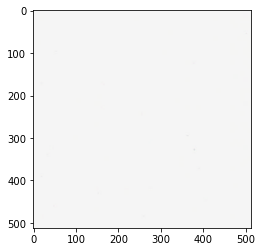

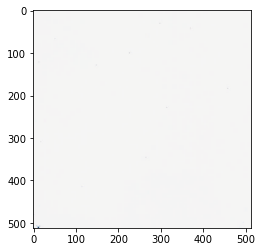

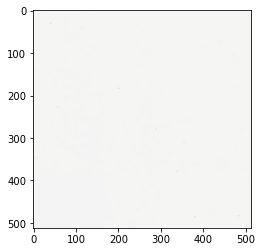

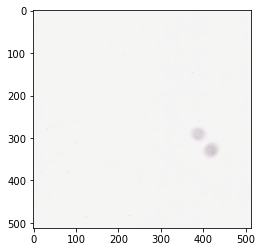

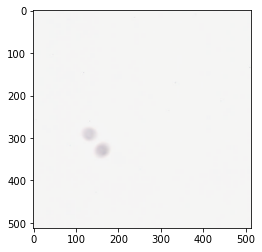

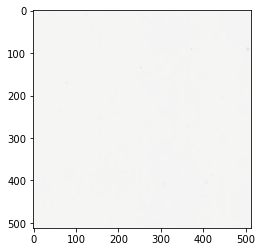

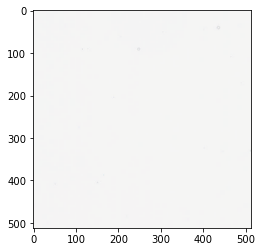

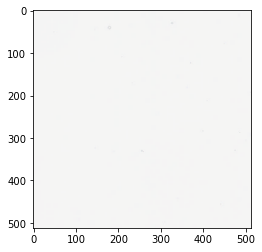

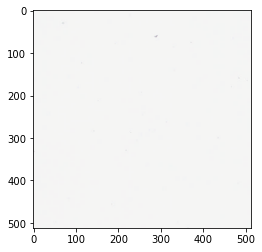

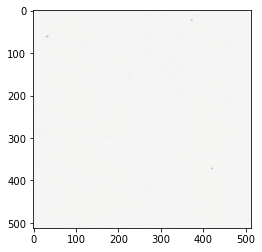

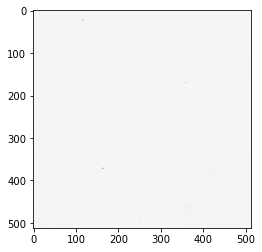

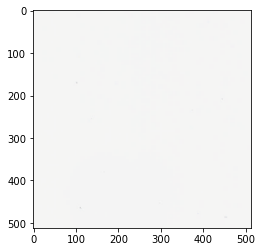

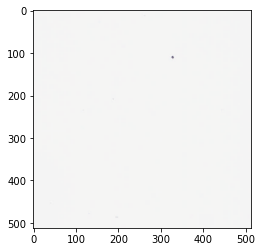

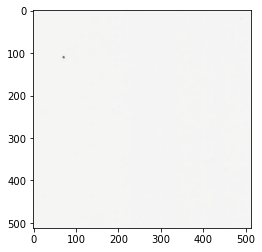

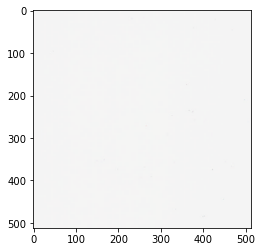

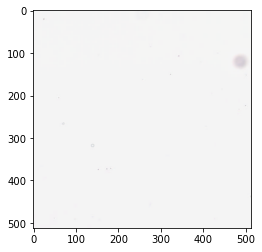

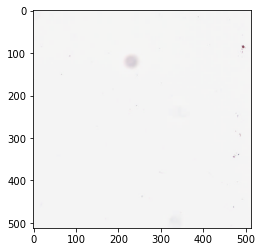

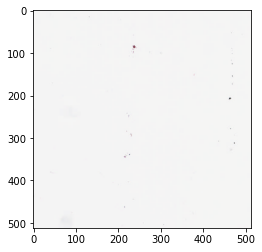

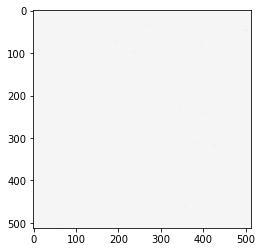

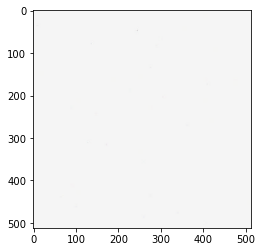

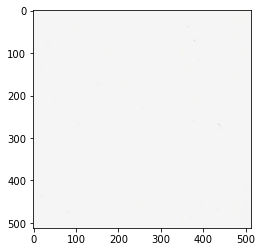

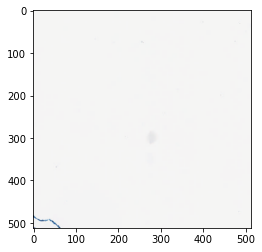

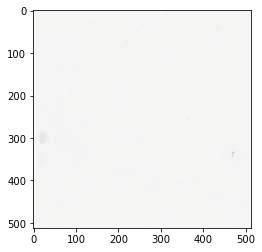

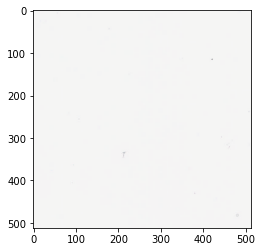

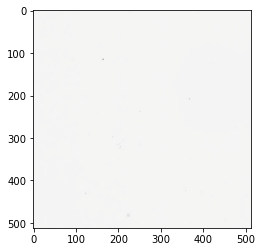

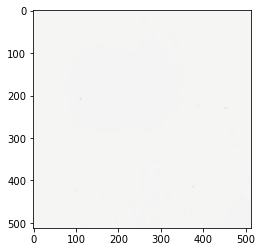

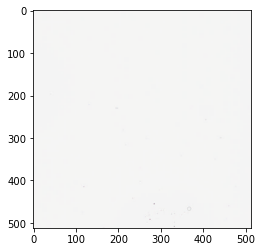

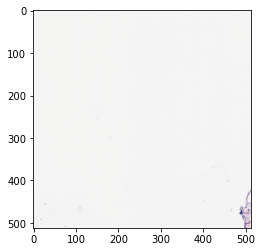

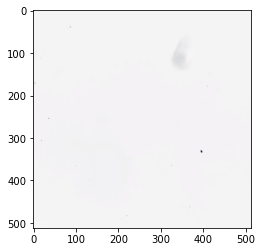

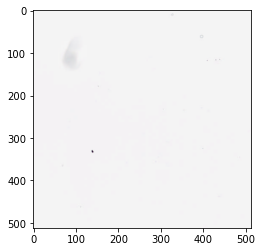

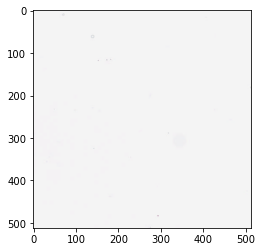

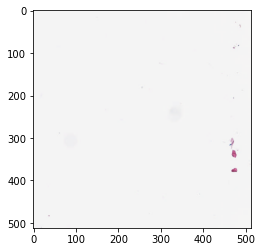

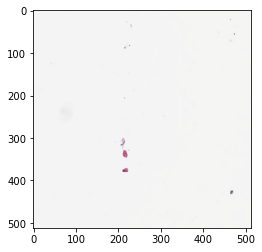

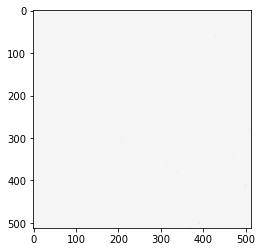

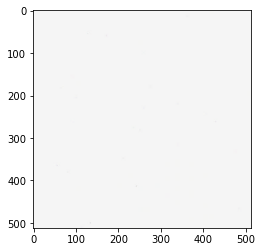

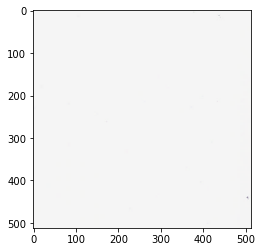

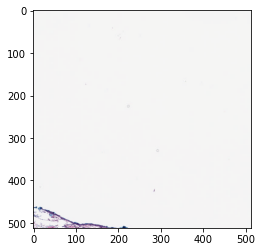

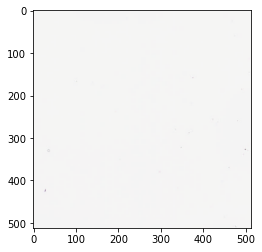

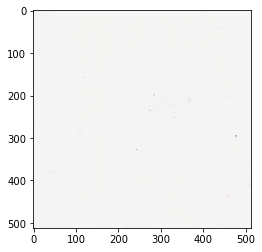

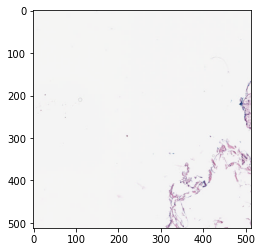

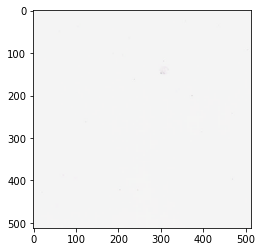

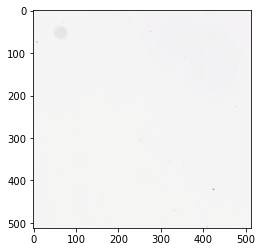

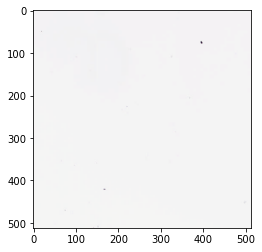

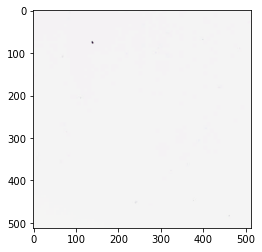

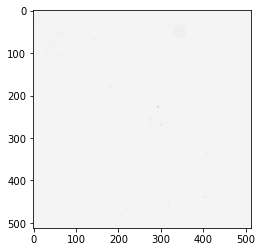

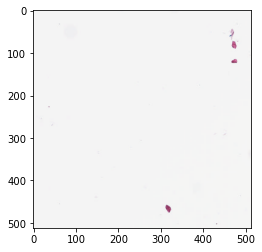

KeyboardInterrupt: 

In [42]:
tissue_mask = get_otsu_mask(wsi_array)

for i in range(0, h_, int(PATCH_SIZE[1] * (1-OVERLAP_RATIO))):
    if i+PATCH_SIZE[1] > h_:
        continue
    for j in range(0, w_, int(PATCH_SIZE[0] * (1-OVERLAP_RATIO))):
        if j+PATCH_SIZE[0] > w_:
            continue
        
        patch_mask = tissue_mask[i:i+PATCH_SIZE[1], j:j+PATCH_SIZE[0]]
        if not is_inside_tissue(patch_mask):
            patch = wsi_array[i:i+PATCH_SIZE[1], j:j+PATCH_SIZE[0], :]
            plt.imshow(patch)
            plt.show()

            del patch
            gc.collect()

##### ex) tissue patch

In [21]:
TISSUE_AREA_RATIO = 0.0

def is_inside_tissue(_mask):
    tissue_area = np.sum(_mask) // 255
    mask_area = np.prod(PATCH_SIZE)
    return (tissue_area / mask_area) > TISSUE_AREA_RATIO

In [ ]:
tissue_mask = get_otsu_mask(wsi_array)

for i in range(0, h_, int(PATCH_SIZE[1] * (1-OVERLAP_RATIO))):
    if i+PATCH_SIZE[1] > h_:
        continue
    for j in range(0, w_, int(PATCH_SIZE[0] * (1-OVERLAP_RATIO))):
        if j+PATCH_SIZE[0] > w_:
            continue
        
        patch_mask = tissue_mask[i:i+PATCH_SIZE[1], j:j+PATCH_SIZE[0]]
        if not is_inside_tissue(patch_mask):
            continue
            
        patch = wsi_array[i:i+PATCH_SIZE[1], j:j+PATCH_SIZE[0], :]
        plt.imshow(patch)
        plt.show()

        del patch
        gc.collect()

##### ex) tissue 영역이 patch에서 80% 이상인 경우만 추출

In [23]:
TISSUE_AREA_RATIO = 0.8

def is_inside_tissue(_mask):
    tissue_area = np.sum(_mask) // 255
    mask_area = np.prod(PATCH_SIZE)
    return (tissue_area / mask_area) > TISSUE_AREA_RATIO